## Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.layers import LSTM, Dense



Don't run Stock Prices Dataset code because yahoo has stopped download option for free historic stock prices  after this data set was downloded.

## Stock Prices Dataset

In [ ]:
pip install yfinance pandas

In [ ]:
import yfinance as yf

# List of 30 unique stocks with market cap and sector info
stocks = {
    "Technology": {
        "Large-Cap": ["AAPL", "MSFT", "NVDA", "GOOGL"],
        "Mid-Cap": ["ADBE", "NOW"],
        "Small-Cap": ["RNG"]
    },
    "Healthcare & Biotechnology": {
        "Large-Cap": ["JNJ", "UNH"],
        "Mid-Cap": ["MRNA", "PFE"],
        "Small-Cap": ["NVAX"]
    },
    "Energy": {
        "Large-Cap": ["XOM","TSLA","CVX"],
        "Mid-Cap": ["MRO"],
        "Small-Cap": ["PLUG", "RRC"]
    },
    "Financials": {
        "Large-Cap": ["JPM", "BRK-B", "V"],
        "Mid-Cap": ["AXP", "DFS"],
        "Small-Cap": ["FRCB","SOFI"]
    },
    "Consumer Staples & Discretionary": {
        "Large-Cap": ["AMZN","PEP"],
        "Mid-Cap": ["LULU"],
        "Small-Cap": ["OLLI"]
    },
    "Industrials & Transportation": {
        "Large-Cap": ["BA", "HON"],
        "Mid-Cap": ["CAT"],
        "Small-Cap": ["ALK", "SPR"]
    },
    "Real Estate": {
        "Large-Cap": ["AMT","PLD"],
        "Mid-Cap": ["PSA"],
        "Small-Cap": ["WPC"]
    }
}

# Define the date range
start_date = "2019-01-01"
end_date = "2024-10-01"

# Flatten the stock list into a DataFrame with cap and sector info
stock_list = [
    {"Ticker": ticker, "Sector": sector, "Cap": cap}
    for sector, caps in stocks.items()
    for cap, tickers in caps.items()
    for ticker in tickers
]
stock_info_df = pd.DataFrame(stock_list)

# Fetch stock data
def fetch_data(tickers):
    return yf.download(tickers, start=start_date, end=end_date, group_by="ticker")

tickers = stock_info_df["Ticker"].tolist()
stock_data = fetch_data(tickers)

# Extract required data: Open, Close, High, Low, Adjusted Close, and Variance
stock_stats = []
for ticker in tickers:
    df = stock_data[ticker].reset_index()
    for _, row in df.iterrows():
        # Check if High and Low values are not NaN
        if pd.notna(row["High"]) and pd.notna(row["Low"]):
            variance = (row["High"] - row["Low"]) ** 2  # Variance as square of the difference
        else:
            variance = None  # Set to None if data is missing

        stock_stats.append({
            "Ticker": ticker,
            "Date": row["Date"],
            "Open": row["Open"],
            "Close": row["Close"],
            "Adj Close": row["Adj Close"],
            "High": row["High"],
            "Low": row["Low"],
            "Variance": variance
        })

# Convert to DataFrame
stock_stats_df = pd.DataFrame(stock_stats)

# Remove empty rows (rows with NaN in any of the key columns)
stock_stats_df = stock_stats_df.dropna(subset=["Open", "Close", "Adj Close", "High", "Low"])

# Merge stock info with statistical data
merged_df = pd.merge(stock_stats_df, stock_info_df, on="Ticker", how="inner")

# Save to CSV (Optional)
merged_df.to_csv("stock_data.csv", index=False)

# Display the first few rows
print(merged_df.head())
print("Data saved to 'stock_data.csv'")


## News Dataset

### AAPL New Data

In [ ]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
from textblob import TextBlob

# Define the base URL
base_url = 'https://markets.businessinsider.com/news/aapl-stock?p='

# Initialize DataFrame with columns
columns = ['datetime', 'title', 'source', 'link', 'top_sentiment', 'sentiment_score']
df = pd.DataFrame(columns=columns)

# Loop through pages 1 to 200
for page_num in range(1, 201):
    url = base_url + str(page_num)
    response = requests.get(url)

    # Check if the request was successful
    if response.status_code == 200:
        html = response.text
        soup = BeautifulSoup(html, 'lxml')
        articles = soup.find_all('div', class_='latest-news__story')

        # Counter to keep track of articles scraped
        counter = 0

        for article in articles:
            try:
                # Extracting each element
                datetime = article.find('time', class_='latest-news__date').get('datetime')
                title = article.find('a', class_='news-link').text.strip()
                source = article.find('span', class_='latest-news__source').text.strip()
                link = article.find('a', class_='news-link').get('href')

                # Full URL for link
                link = 'https://markets.businessinsider.com' + link

                # Sentiment analysis on the title
                sentiment = TextBlob(title).sentiment
                top_sentiment = 'positive' if sentiment.polarity > 0 else 'negative' if sentiment.polarity < 0 else 'neutral'
                sentiment_score = sentiment.polarity

                # Append data to DataFrame
                df = pd.concat([pd.DataFrame([[datetime, title, source, link, top_sentiment, sentiment_score]], columns=df.columns), df], ignore_index=True)
                counter += 1

            except AttributeError:
                # Skip if there's a missing element
                continue

        print(f'Page {page_num} scraped with {counter} articles.')

    else:
        print(f"Failed to retrieve page {page_num}. Status code: {response.status_code}")
        break  # Stop if there is a request failure

# Save to CSV after all pages are scraped
df.to_csv('Stock_news_AAPL.csv', index=False)
print(f'Total of {len(df)} articles scraped across {page_num} pages.')


In [ ]:
A = pd.read_csv('Stock_news_AAPL.csv')

A.head(50)

In [ ]:
# Remove duplicate rows based on the 'title' column
A.drop_duplicates(subset='title', inplace=True)

# Save the cleaned DataFrame to a new CSV file
A.to_csv('AAPL_news.csv', index=False)

print(f'Total of {len(s)} unique articles saved to AAPL_news.csv.')


### NVDA News Data

In [ ]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
from textblob import TextBlob

# Define the base URL
base_url = 'https://markets.businessinsider.com/news/nvda-stock?p='

# Initialize DataFrame with columns
columns = ['datetime', 'title', 'source', 'link', 'top_sentiment', 'sentiment_score']
df = pd.DataFrame(columns=columns)

# Loop through pages 1 to 200
for page_num in range(1, 201):
    url = base_url + str(page_num)
    response = requests.get(url)

    # Check if the request was successful
    if response.status_code == 200:
        html = response.text
        soup = BeautifulSoup(html, 'lxml')
        articles = soup.find_all('div', class_='latest-news__story')

        # Counter to keep track of articles scraped
        counter = 0

        for article in articles:
            try:
                # Extracting each element
                datetime = article.find('time', class_='latest-news__date').get('datetime')
                title = article.find('a', class_='news-link').text.strip()
                source = article.find('span', class_='latest-news__source').text.strip()
                link = article.find('a', class_='news-link').get('href')

                # Full URL for link
                link = 'https://markets.businessinsider.com' + link

                # Sentiment analysis on the title
                sentiment = TextBlob(title).sentiment
                top_sentiment = 'positive' if sentiment.polarity > 0 else 'negative' if sentiment.polarity < 0 else 'neutral'
                sentiment_score = sentiment.polarity

                # Append data to DataFrame
                df = pd.concat([pd.DataFrame([[datetime, title, source, link, top_sentiment, sentiment_score]], columns=df.columns), df], ignore_index=True)
                counter += 1

            except AttributeError:
                # Skip if there's a missing element
                continue

        print(f'Page {page_num} scraped with {counter} articles.')

    else:
        print(f"Failed to retrieve page {page_num}. Status code: {response.status_code}")
        break  # Stop if there is a request failure

# Save to CSV after all pages are scraped
df.to_csv('Stock_news_NVDA.csv', index=False)
print(f'Total of {len(df)} articles scraped across {page_num} pages.')


In [ ]:
N = pd.read_csv('Stock_news_NVDA.csv')

N.head(50)

In [ ]:
# Remove duplicate rows based on the 'title' column
N.drop_duplicates(subset='title', inplace=True)

# Save the cleaned DataFrame to a new CSV file
N.to_csv('NVDA_news.csv', index=False)

print(f'Total of {len(s)} unique articles saved to NVDA_news.csv.')


### MSFT News Data

In [ ]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
from textblob import TextBlob

# Define the base URL
base_url = 'https://markets.businessinsider.com/news/msft-stock?p='

# Initialize DataFrame with columns
columns = ['datetime', 'title', 'source', 'link', 'top_sentiment', 'sentiment_score']
df = pd.DataFrame(columns=columns)

# Loop through pages 1 to 200
for page_num in range(1, 201):
    url = base_url + str(page_num)
    response = requests.get(url)

    # Check if the request was successful
    if response.status_code == 200:
        html = response.text
        soup = BeautifulSoup(html, 'lxml')
        articles = soup.find_all('div', class_='latest-news__story')

        # Counter to keep track of articles scraped
        counter = 0

        for article in articles:
            try:
                # Extracting each element
                datetime = article.find('time', class_='latest-news__date').get('datetime')
                title = article.find('a', class_='news-link').text.strip()
                source = article.find('span', class_='latest-news__source').text.strip()
                link = article.find('a', class_='news-link').get('href')

                # Full URL for link
                link = 'https://markets.businessinsider.com' + link

                # Sentiment analysis on the title
                sentiment = TextBlob(title).sentiment
                top_sentiment = 'positive' if sentiment.polarity > 0 else 'negative' if sentiment.polarity < 0 else 'neutral'
                sentiment_score = sentiment.polarity

                # Append data to DataFrame
                df = pd.concat([pd.DataFrame([[datetime, title, source, link, top_sentiment, sentiment_score]], columns=df.columns), df], ignore_index=True)
                counter += 1

            except AttributeError:
                # Skip if there's a missing element
                continue

        print(f'Page {page_num} scraped with {counter} articles.')

    else:
        print(f"Failed to retrieve page {page_num}. Status code: {response.status_code}")
        break  # Stop if there is a request failure

# Save to CSV after all pages are scraped
df.to_csv('Stock_news_MSFT.csv', index=False)
print(f'Total of {len(df)} articles scraped across {page_num} pages.')


In [ ]:
M = pd.read_csv('Stock_news_MSFT.csv')

M.head(50)

In [ ]:
# Remove duplicate rows based on the 'title' column
M.drop_duplicates(subset='title', inplace=True)

# Save the cleaned DataFrame to a new CSV file
M.to_csv('MSFT_news.csv', index=False)

print(f'Total of {len(s)} unique articles saved to MSFT_news.csv.')

### NOW News Data

In [ ]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
from textblob import TextBlob

# Define the base URL
base_url = 'https://markets.businessinsider.com/news/now-stock?p='

# Initialize DataFrame with columns
columns = ['datetime', 'title', 'source', 'link', 'top_sentiment', 'sentiment_score']
df = pd.DataFrame(columns=columns)

# Loop through pages 1 to 200
for page_num in range(1, 201):
    url = base_url + str(page_num)
    response = requests.get(url)

    # Check if the request was successful
    if response.status_code == 200:
        html = response.text
        soup = BeautifulSoup(html, 'lxml')
        articles = soup.find_all('div', class_='latest-news__story')

        # Counter to keep track of articles scraped
        counter = 0

        for article in articles:
            try:
                # Extracting each element
                datetime = article.find('time', class_='latest-news__date').get('datetime')
                title = article.find('a', class_='news-link').text.strip()
                source = article.find('span', class_='latest-news__source').text.strip()
                link = article.find('a', class_='news-link').get('href')

                # Full URL for link
                link = 'https://markets.businessinsider.com' + link

                # Sentiment analysis on the title
                sentiment = TextBlob(title).sentiment
                top_sentiment = 'positive' if sentiment.polarity > 0 else 'negative' if sentiment.polarity < 0 else 'neutral'
                sentiment_score = sentiment.polarity

                # Append data to DataFrame
                df = pd.concat([pd.DataFrame([[datetime, title, source, link, top_sentiment, sentiment_score]], columns=df.columns), df], ignore_index=True)
                counter += 1

            except AttributeError:
                # Skip if there's a missing element
                continue

        print(f'Page {page_num} scraped with {counter} articles.')

    else:
        print(f"Failed to retrieve page {page_num}. Status code: {response.status_code}")
        break  # Stop if there is a request failure

# Save to CSV after all pages are scraped
df.to_csv('Stock_news_Now.csv', index=False)
print(f'Total of {len(df)} articles scraped across {page_num} pages.')


In [ ]:
No = pd.read_csv('Stock_news_Now.csv')

No.head(50)

In [ ]:
# Remove duplicate rows based on the 'title' column
No.drop_duplicates(subset='title', inplace=True)

# Save the cleaned DataFrame to a new CSV file
No.to_csv('Now_news.csv', index=False)

print(f'Total of {len(s)} unique articles saved to Now_news.csv.')

### ADBE New Data

In [ ]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
from textblob import TextBlob

# Define the base URL
base_url = 'https://markets.businessinsider.com/news/adbe-stock?p='

# Initialize DataFrame with columns
columns = ['datetime', 'title', 'source', 'link', 'top_sentiment', 'sentiment_score']
df = pd.DataFrame(columns=columns)

# Loop through pages 1 to 200
for page_num in range(1, 201):
    url = base_url + str(page_num)
    response = requests.get(url)

    # Check if the request was successful
    if response.status_code == 200:
        html = response.text
        soup = BeautifulSoup(html, 'lxml')
        articles = soup.find_all('div', class_='latest-news__story')

        # Counter to keep track of articles scraped
        counter = 0

        for article in articles:
            try:
                # Extracting each element
                datetime = article.find('time', class_='latest-news__date').get('datetime')
                title = article.find('a', class_='news-link').text.strip()
                source = article.find('span', class_='latest-news__source').text.strip()
                link = article.find('a', class_='news-link').get('href')

                # Full URL for link
                link = 'https://markets.businessinsider.com' + link

                # Sentiment analysis on the title
                sentiment = TextBlob(title).sentiment
                top_sentiment = 'positive' if sentiment.polarity > 0 else 'negative' if sentiment.polarity < 0 else 'neutral'
                sentiment_score = sentiment.polarity

                # Append data to DataFrame
                df = pd.concat([pd.DataFrame([[datetime, title, source, link, top_sentiment, sentiment_score]], columns=df.columns), df], ignore_index=True)
                counter += 1

            except AttributeError:
                # Skip if there's a missing element
                continue

        print(f'Page {page_num} scraped with {counter} articles.')

    else:
        print(f"Failed to retrieve page {page_num}. Status code: {response.status_code}")
        break  # Stop if there is a request failure

# Save to CSV after all pages are scraped
df.to_csv('Stock_news_Adbe.csv', index=False)
print(f'Total of {len(df)} articles scraped across {page_num} pages.')


In [ ]:
Ad = pd.read_csv('Stock_news_Adbe.csv')

Ad.head(50)

In [ ]:
# Remove duplicate rows based on the 'title' column
Ad.drop_duplicates(subset='title', inplace=True)

# Save the cleaned DataFrame to a new CSV file
Ad.to_csv('Adbe_news.csv', index=False)

print(f'Total of {len(s)} unique articles saved to Adbe_news.csv.')

## EDA

In [ ]:
stocks = pd.read_csv('stock_data.csv')
stocks.head()

Ticker                       Date       Open      Close  Adj Close  \
0   AAPL  2019-01-02 00:00:00+00:00  38.722500  39.480000  37.750095   
1   AAPL  2019-01-03 00:00:00+00:00  35.994999  35.547501  33.989899   
2   AAPL  2019-01-04 00:00:00+00:00  36.132500  37.064999  35.440910   
3   AAPL  2019-01-07 00:00:00+00:00  37.174999  36.982498  35.362015   
4   AAPL  2019-01-08 00:00:00+00:00  37.389999  37.687500  36.036125   

        High        Low  Variance      Sector        Cap  
0  39.712502  38.557499  1.334031  Technology  Large-Cap  
1  36.430000  35.500000  0.864901  Technology  Large-Cap  
2  37.137501  35.950001  1.410156  Technology  Large-Cap  
3  37.207500  36.474998  0.536559  Technology  Large-Cap  
4  37.955002  37.130001  0.680626  Technology  Large-Cap

In [ ]:
stocks.shape

(54443, 10)

###Descriptive Statistics

In [ ]:
stocks.describe()

Open         Close     Adj Close          High           Low  \
count  54443.000000  54443.000000  54443.000000  54443.000000  54443.000000   
mean     156.045536    156.049912    151.084236    158.023723    153.995631   
std      131.456304    131.458062    130.556240    132.954685    129.866013   
min        0.000200      0.010000      0.010000      0.014900      0.000200   
25%       55.253750     55.220001     52.518665     56.179251     54.375334   
50%      131.919998    131.940002    123.699997    133.550003    130.229996   
75%      212.160004    212.240005    204.066132    214.750000    209.575005   
max      936.880005    937.359985    937.359985    945.460022    922.919983   

           Variance  
count  54443.000000  
mean      37.216424  
std      126.441233  
min        0.000000  
25%        1.690008  
50%        6.656370  
75%       24.700912  
max     7072.302863

### Checking for Missing values

In [ ]:
stocks.isnull().sum()

Ticker       0
Date         0
Open         0
Close        0
Adj Close    0
High         0
Low          0
Variance     0
Sector       0
Cap          0
dtype: int64

In [ ]:
stocks.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54443 entries, 0 to 54442
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Ticker     54443 non-null  object 
 1   Date       54443 non-null  object 
 2   Open       54443 non-null  float64
 3   Close      54443 non-null  float64
 4   Adj Close  54443 non-null  float64
 5   High       54443 non-null  float64
 6   Low        54443 non-null  float64
 7   Variance   54443 non-null  float64
 8   Sector     54443 non-null  object 
 9   Cap        54443 non-null  object 
dtypes: float64(6), object(4)
memory usage: 4.2+ MB


### Checking for duplicate values

In [ ]:
stocks.duplicated().sum()


0

## Visulalizations

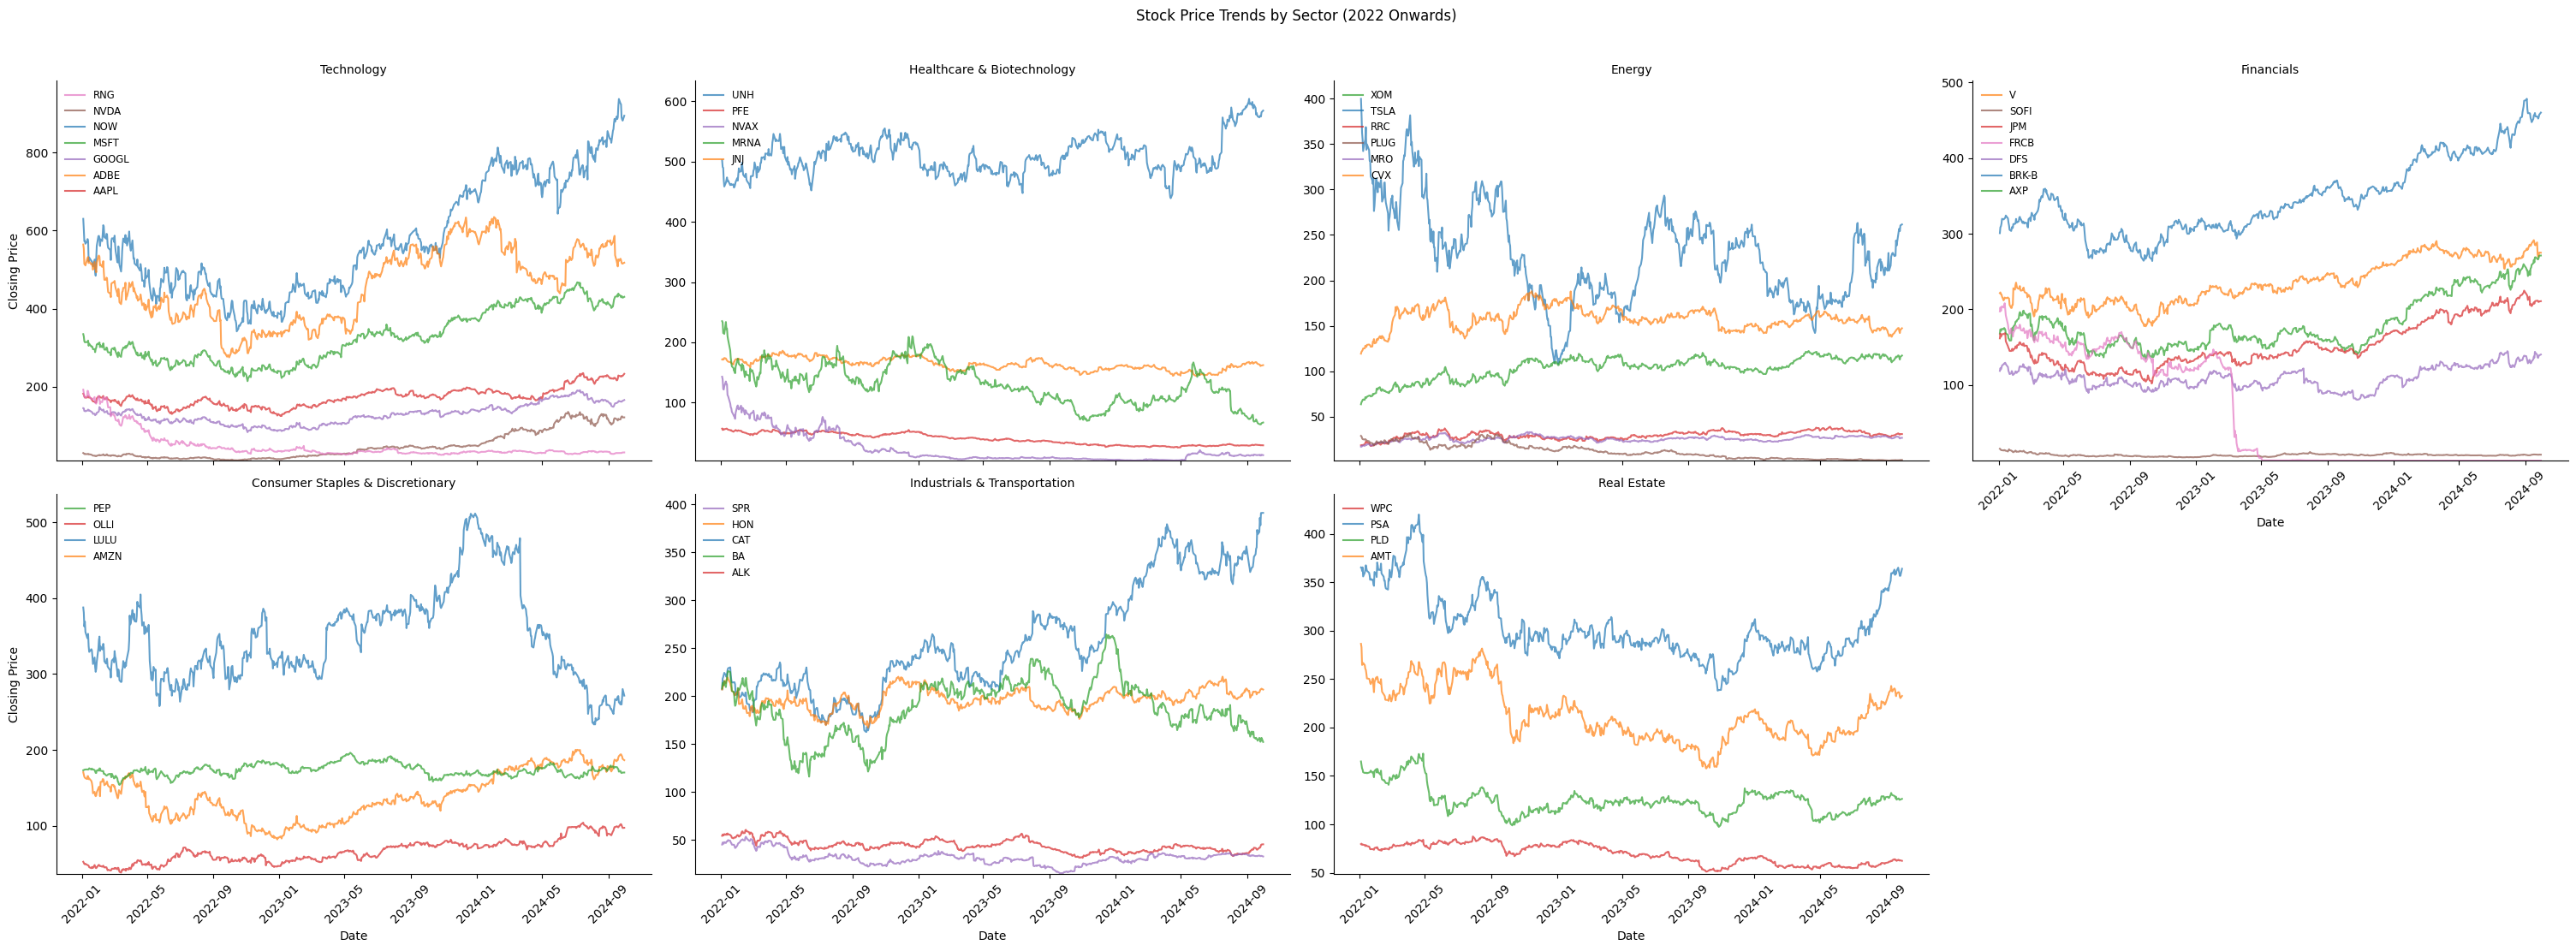

In [ ]:
# Ensure Date is in datetime format
stocks['Date'] = pd.to_datetime(stocks['Date'])

# Filter the data to include only dates from 2022 onwards
stocks_filtered = stocks[stocks['Date'] >= '2022-01-01']

# Create a FacetGrid for sectors
g = sns.FacetGrid(
    stocks_filtered, col="Sector", col_wrap=4, height=5, aspect=1.5, sharey=False
)

# Function to plot each sector
def plot_sector(data, color):
    # Sort tickers by last visible closing price in descending order
    tickers = (
        data.groupby("Ticker")["Close"]
        .last()
        .sort_values(ascending=False)
        .index
    )
    for ticker in tickers:
        subset = data[data["Ticker"] == ticker]
        plt.plot(subset["Date"], subset["Close"], label=ticker, alpha=0.7)

    # Set y-axis limits to start from the minimum closing price
    ymin = data["Close"].min() * 0.95  # Add 5% padding below the minimum
    ymax = data["Close"].max() * 1.05  # Add 5% padding above the maximum
    plt.ylim(ymin, ymax)

# Map the function to the FacetGrid
g.map_dataframe(plot_sector)

# Adjust titles, legends, and x-axis labels
for ax in g.axes.flat:
    # Sort legend handles and labels by ticker order
    handles, labels = ax.get_legend_handles_labels()
    sorted_legend = sorted(zip(labels, handles), key=lambda x: x[0], reverse=True)
    if sorted_legend:  # Ensure there's data for the legend
        sorted_labels, sorted_handles = zip(*sorted_legend)
        ax.legend(
            sorted_handles,
            sorted_labels,
            loc="upper left",
            fontsize="small",
            frameon=False,
        )
    ax.set_xlabel("Date")
    ax.set_ylabel("Closing Price")
    ax.tick_params(axis="x", labelrotation=45)  # Force x-axis labels to rotate

# Set overall title and axis labels
g.set_titles("{col_name}")
g.fig.suptitle("Stock Price Trends by Sector (2022 Onwards)", y=1.05)
g.set_axis_labels("Date", "Closing Price")



# Show the plot
plt.show()


In [ ]:
stocks['Date'] = stocks['Date'].dt.tz_localize(None)
comparison_date = pd.Timestamp('2020-04-01')
result = stocks[stocks['Date'] >= comparison_date]


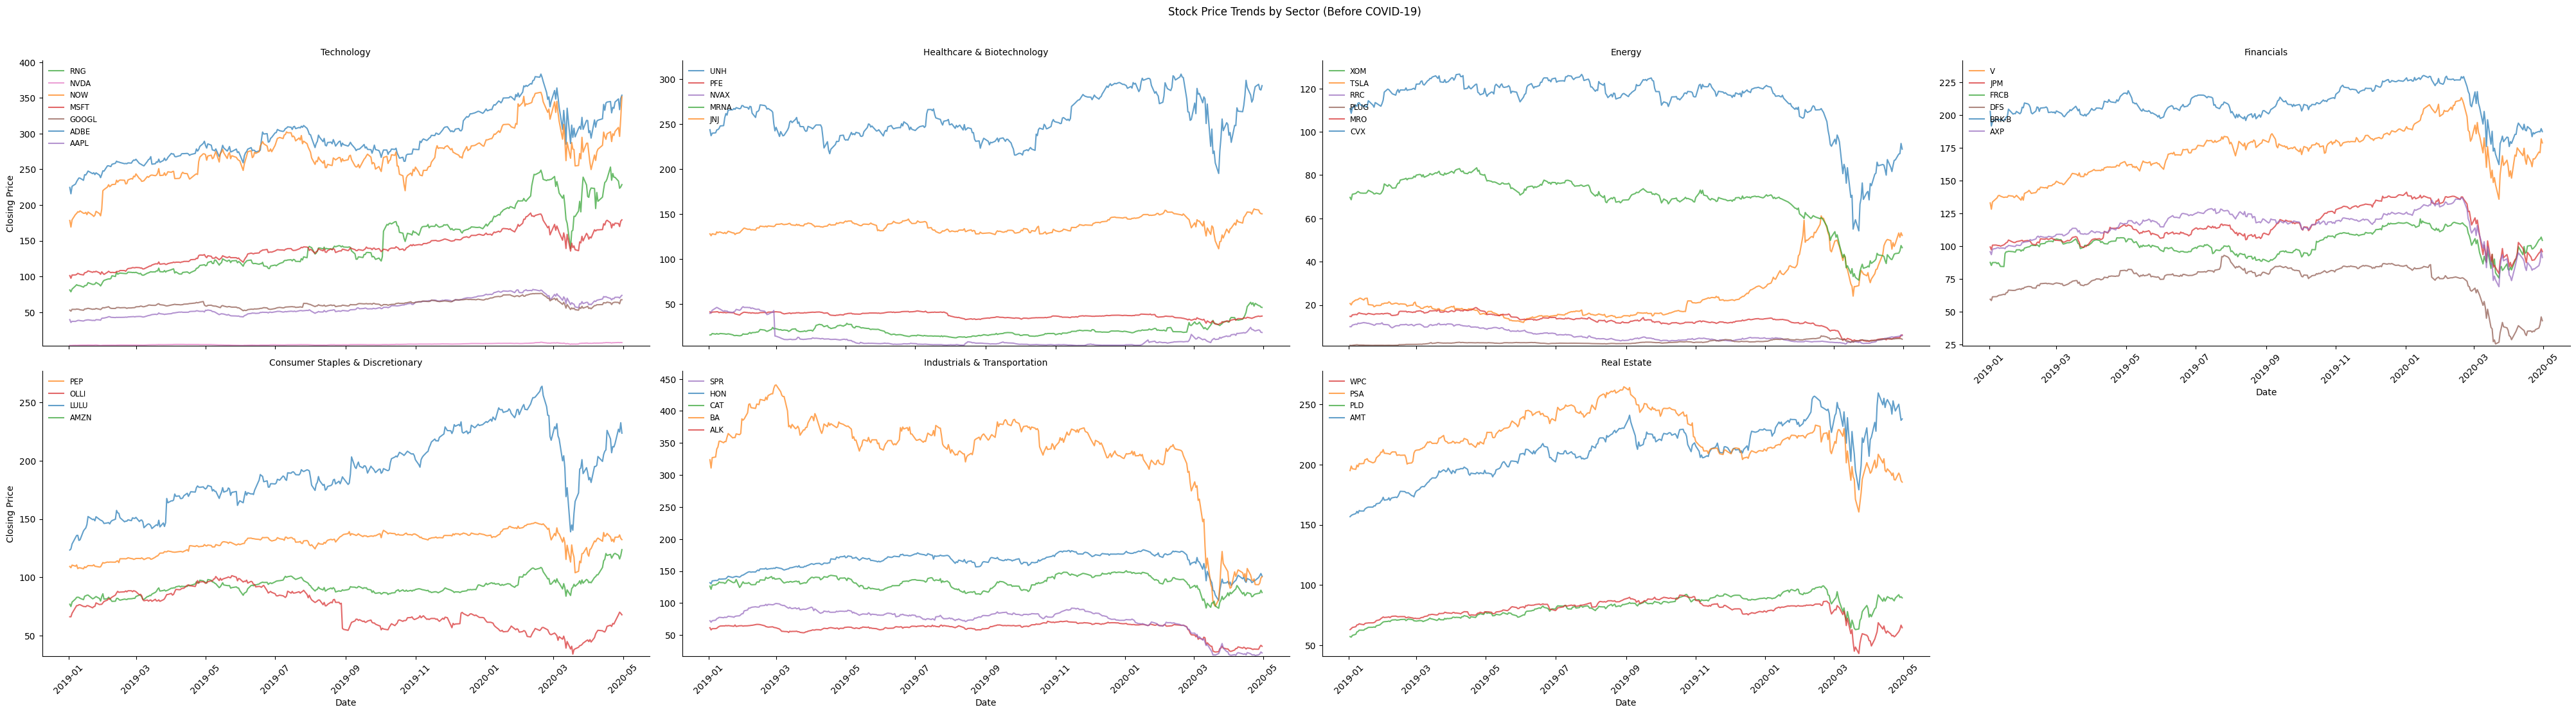

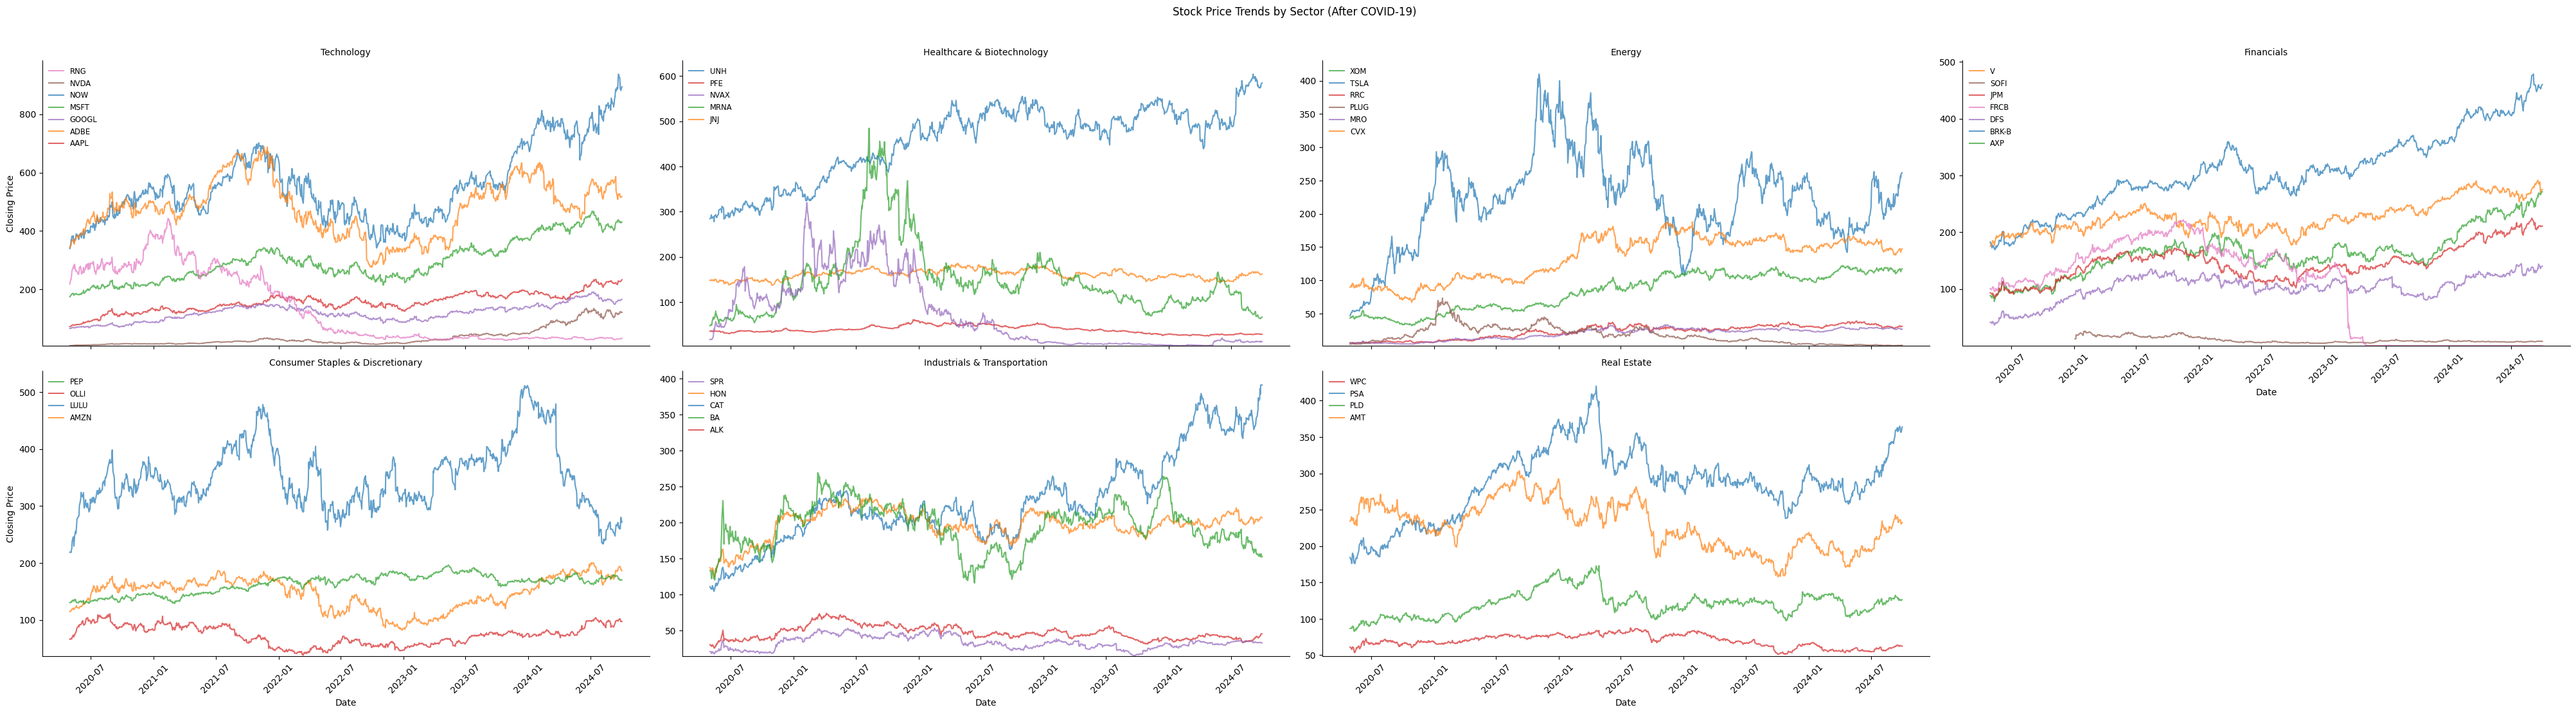

In [ ]:
# Ensure Date is in datetime format
stocks['Date'] = pd.to_datetime(stocks['Date'])

# Define the cutoff date for COVID-19
covid_date = pd.to_datetime("2020-05-01")

# Split the dataset into before and after COVID-19
stocks_before_covid = stocks[stocks['Date'] < covid_date]
stocks_after_covid = stocks[stocks['Date'] >= covid_date]

# Define a function to plot each dataset
def plot_data(data, title):
    # Create FacetGrid for sectors
    g = sns.FacetGrid(data, col="Sector", col_wrap=4, height=5, aspect=2, sharey=False)

    # Function to plot each sector
    def plot_sector(data, color):
        # Sort tickers by last visible closing price in descending order
        tickers = (
            data.groupby("Ticker")["Close"]
            .last()
            .sort_values(ascending=False)
            .index
        )
        for ticker in tickers:
            subset = data[data["Ticker"] == ticker]
            plt.plot(subset["Date"], subset["Close"], label=ticker, alpha=0.7)

        # Set y-axis limits to start from the minimum closing price
        ymin = data["Close"].min() * 0.95  # Add 5% padding below the minimum
        ymax = data["Close"].max() * 1.05  # Add 5% padding above the maximum
        plt.ylim(ymin, ymax)

    # Map the function to the FacetGrid
    g.map_dataframe(plot_sector)

    # Adjust titles, legends, and x-axis labels
    for ax in g.axes.flat:
        # Sort legend handles and labels by ticker order
        handles, labels = ax.get_legend_handles_labels()
        sorted_legend = sorted(zip(labels, handles), key=lambda x: x[0], reverse=True)
        if sorted_legend:  # Ensure there's data for the legend
            sorted_labels, sorted_handles = zip(*sorted_legend)
            ax.legend(
                sorted_handles,
                sorted_labels,
                loc="upper left",
                fontsize="small",
                frameon=False,
            )
        ax.set_xlabel("Date")
        ax.set_ylabel("Closing Price")
        ax.tick_params(axis="x", labelrotation=45)  # Rotate x-axis labels explicitly

    # Set overall title and axis labels
    g.set_titles("{col_name}")
    g.fig.suptitle(title, y=1.05)
    g.set_axis_labels("Date", "Closing Price")

    # Show the plot
    plt.show()

# Plot data for before COVID-19
plot_data(stocks_before_covid, "Stock Price Trends by Sector (Before COVID-19)")

# Plot data for after COVID-19
plot_data(stocks_after_covid, "Stock Price Trends by Sector (After COVID-19)")


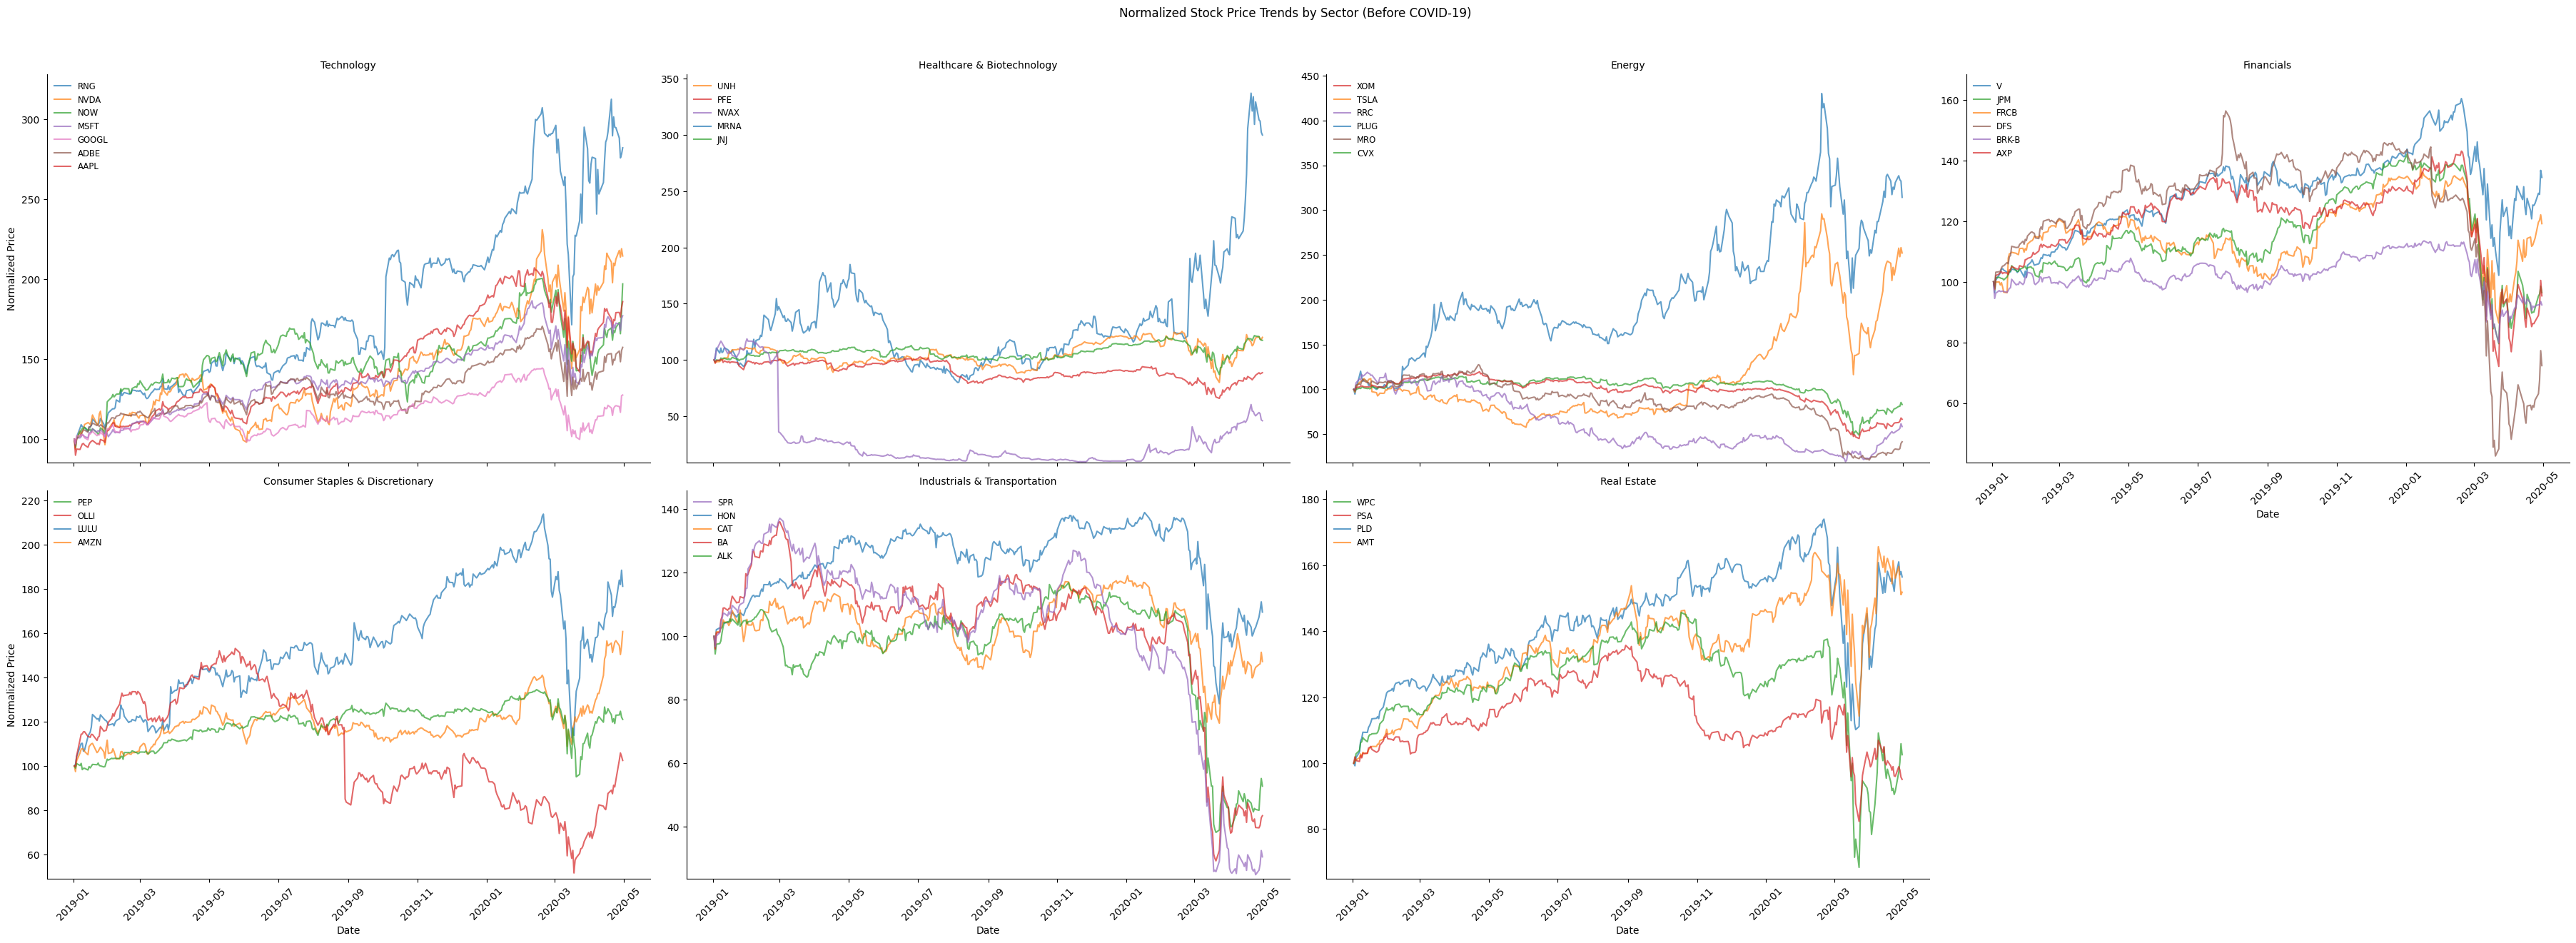

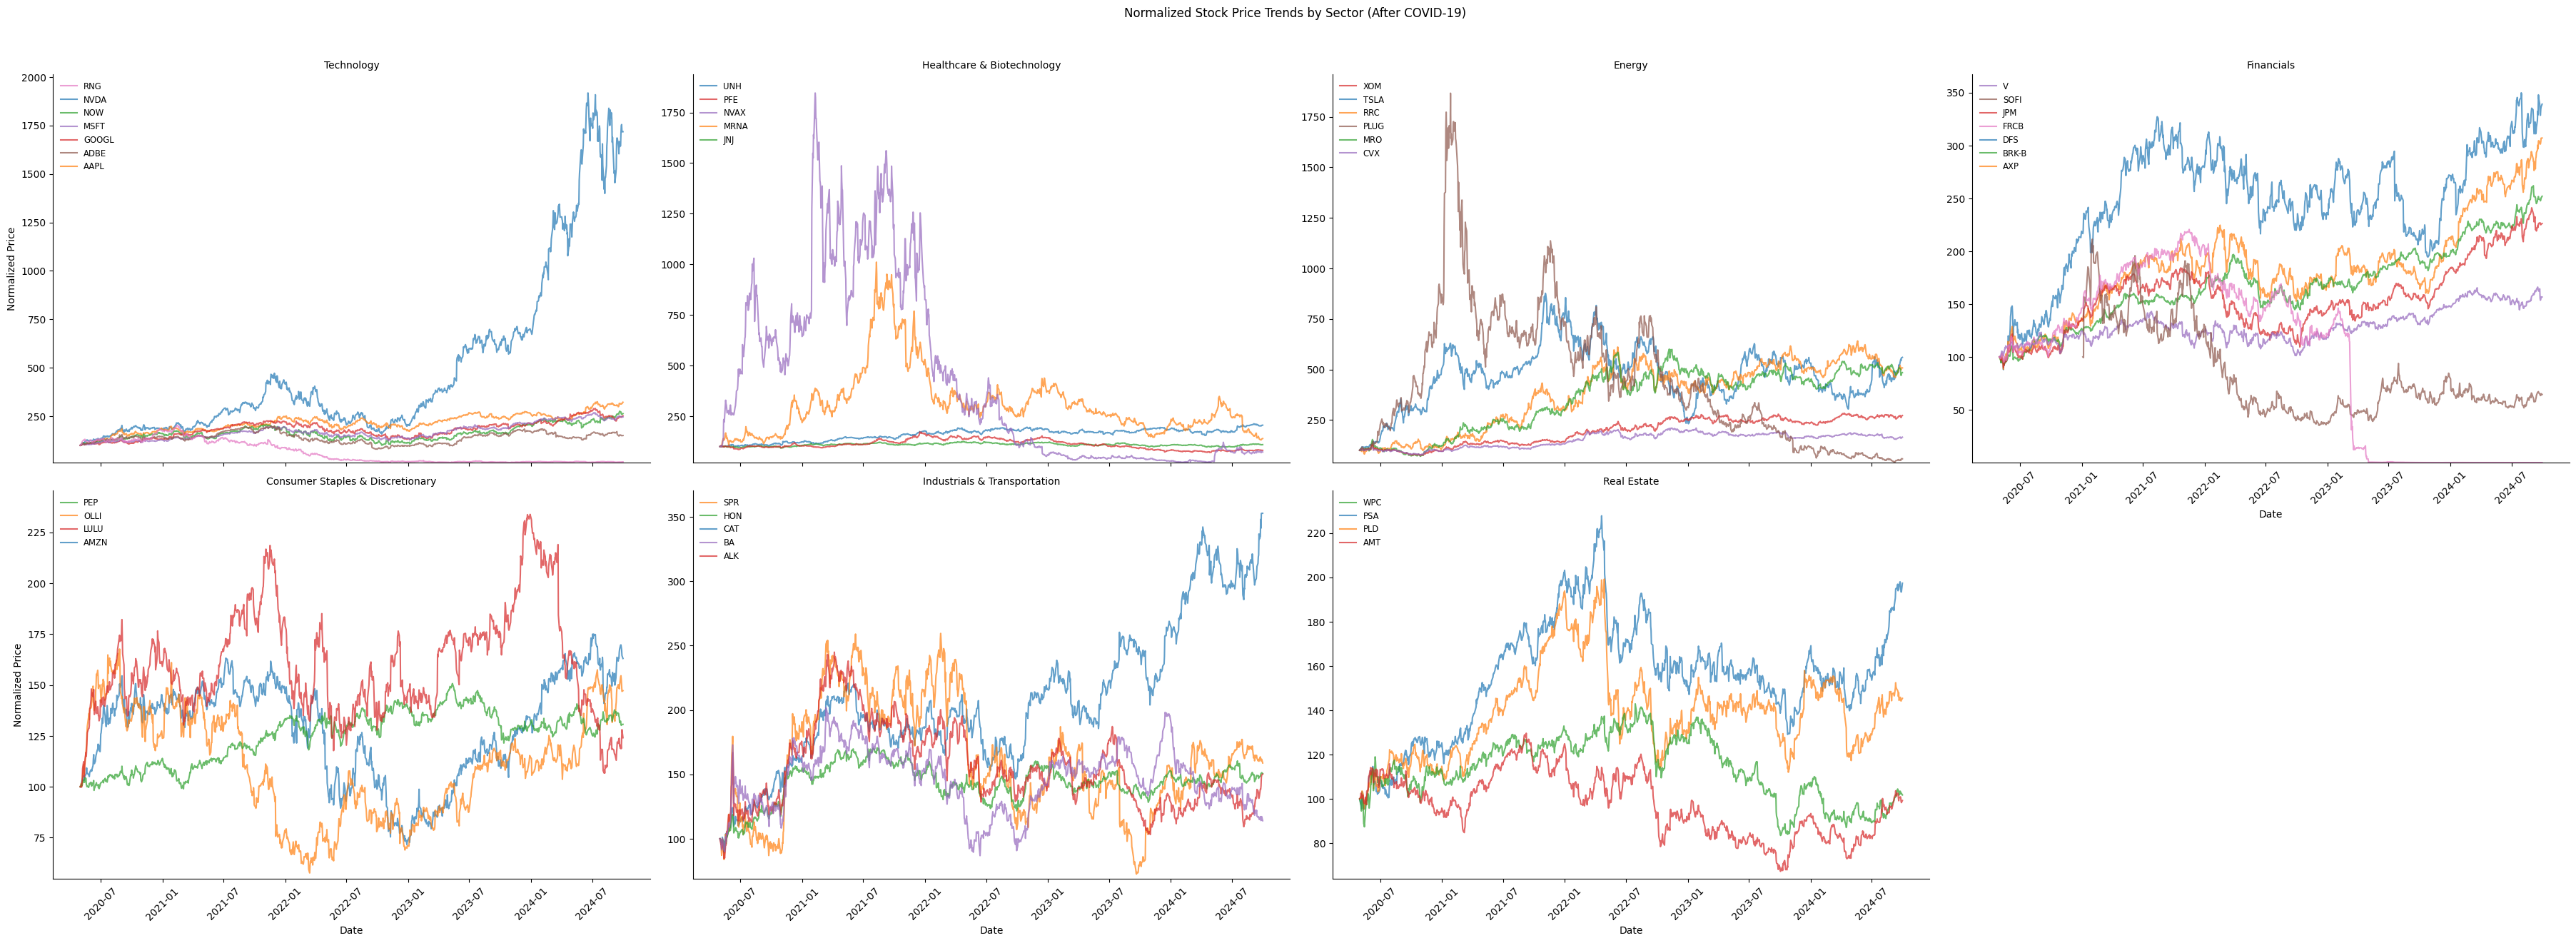

In [ ]:
# Ensure Date is in datetime format
stocks['Date'] = pd.to_datetime(stocks['Date'])

# Define the cutoff date for COVID-19
covid_date = pd.to_datetime("2020-05-01")

# Normalize the data
def normalize_data(data):
    normalized = data.copy()
    normalized['Normalized Close'] = (
        normalized.groupby('Ticker')['Close'].transform(lambda x: (x / x.iloc[0]) * 100)
    )
    return normalized

# Split and normalize the datasets
stocks_before_covid = normalize_data(stocks[stocks['Date'] < covid_date])
stocks_after_covid = normalize_data(stocks[stocks['Date'] >= covid_date])

# Define a function to plot normalized data
def plot_normalized_data(data, title):
    # Create a FacetGrid for sectors
    g = sns.FacetGrid(data, col="Sector", col_wrap=4, height=6, aspect=1.5, sharey=False)

    # Function to plot each sector
    def plot_sector(data, color):
        # Sort tickers by the last normalized closing price in descending order
        tickers = (
            data.groupby("Ticker")["Normalized Close"]
            .last()
            .sort_values(ascending=False)
            .index
        )
        for ticker in tickers:
            subset = data[data["Ticker"] == ticker]
            plt.plot(subset["Date"], subset["Normalized Close"], label=ticker, alpha=0.7)

        # Set y-axis limits to start from the minimum normalized value
        ymin = data["Normalized Close"].min() * 0.95  # Add 5% padding below the minimum
        ymax = data["Normalized Close"].max() * 1.05  # Add 5% padding above the maximum
        plt.ylim(ymin, ymax)

    # Map the function to the FacetGrid
    g.map_dataframe(plot_sector)

    # Adjust titles, legends, and x-axis labels
    for ax in g.axes.flat:
        # Sort legend handles and labels by ticker order
        handles, labels = ax.get_legend_handles_labels()
        sorted_legend = sorted(zip(labels, handles), key=lambda x: x[0], reverse=True)
        if sorted_legend:  # Ensure there's data for the legend
            sorted_labels, sorted_handles = zip(*sorted_legend)
            ax.legend(
                sorted_handles,
                sorted_labels,
                loc="upper left",
                fontsize="small",
                frameon=False,
            )
        ax.set_xlabel("Date")
        ax.set_ylabel("Normalized Price")
        ax.tick_params(axis="x", labelrotation=45)  # Rotate x-axis labels explicitly

    # Set overall title and axis labels
    g.set_titles("{col_name}")
    g.fig.suptitle(title, y=1.05)
    g.set_axis_labels("Date", "Normalized Price")


    # Show the plot
    plt.show()

# Plot normalized data for before COVID-19
plot_normalized_data(stocks_before_covid, "Normalized Stock Price Trends by Sector (Before COVID-19)")

# Plot normalized data for after COVID-19
plot_normalized_data(stocks_after_covid, "Normalized Stock Price Trends by Sector (After COVID-19)")


In [ ]:
# Define the specific stock ticker you want to normalize
specific_stock = "NVDA"  # Replace with the desired stock ticker

# Filter the data for the specific stock
stock_data = stocks[stocks['Ticker'] == specific_stock].copy()

# Normalize the 'Close' column
stock_data['Normalized Close'] = (stock_data['Close'] / stock_data['Close'].iloc[0]) * 100

# Display the normalized values
print(stock_data[['Date', 'Close', 'Normalized Close']])


           Date       Close  Normalized Close
2892 2019-01-02    3.405500        100.000000
2893 2019-01-03    3.199750         93.958303
2894 2019-01-04    3.404750         99.977982
2895 2019-01-07    3.585000        105.270888
2896 2019-01-08    3.495750        102.650125
...         ...         ...               ...
4333 2024-09-24  120.870003       3549.258701
4334 2024-09-25  123.510002       3626.780340
4335 2024-09-26  124.040001       3642.343364
4336 2024-09-27  121.400002       3564.821725
4337 2024-09-30  121.440002       3565.996322

[1446 rows x 3 columns]


### Technology Sector

### Close Descriptive Statistics

In [ ]:
# Filter the stocks DataFrame for the selected tickers
selected_tickers = ['NVDA', 'MSFT', 'NOW', 'ADBE', 'RNG']
filtered_stocks = stocks[stocks['Ticker'].isin(selected_tickers)]

# Function to calculate additional statistics for each ticker
def calculate_statistics(data):
    return pd.Series({
        'mean': data.mean(),
        'median': data.median(),
        'mode': data.mode().iloc[0] if not data.mode().empty else None,
        'std_dev': data.std(),
        'variance': data.var(),
        'kurtosis': data.kurt(),
        'skewness': data.skew(),
        'min': data.min(),
        'max': data.max(),
        'range': data.max() - data.min(),
        'sum': data.sum(),
        'count': data.count(),
        '25%': data.quantile(0.25),
        '50%': data.quantile(0.5),
        '70%': data.quantile(0.7),
    })

# Group by ticker and calculate statistics for the 'Close' column
statistics = filtered_stocks.groupby('Ticker')['Close'].apply(calculate_statistics)
# Convert the Series to a DataFrame and reset the index
statistics_df = statistics.unstack(level=1)

# Display the DataFrame
print(statistics_df)


# Transpose the DataFrame
statistics_transposed = statistics_df.T

# Display the transposed DataFrame
print(statistics_transposed)


              mean      median        mode     std_dev      variance  \
Ticker                                                                 
ADBE    437.968762  449.434998  484.279999  115.249700  13282.493307   
MSFT    259.939793  254.625000  102.800003   91.432570   8359.914888   
NOW     490.315422  487.925003  185.699997  165.804977  27491.290323   
NVDA     28.129739   16.771625    3.719250   30.462477    927.962485   
RNG     140.233631  115.794998   34.290001  109.074717  11897.293913   

        kurtosis  skewness         min         max       range            sum  \
Ticker                                                                          
ADBE   -1.043745  0.083876  215.699997  688.369995  472.669998  633302.830246   
MSFT   -0.755366  0.210844   97.400002  467.559998  370.159996  375872.939957   
NOW    -0.643895  0.204044  169.119995  937.359985  768.239990  708996.100067   
NVDA    2.964819  1.928407    3.199750  135.580002  132.380252   40675.602994   
RNG    -0

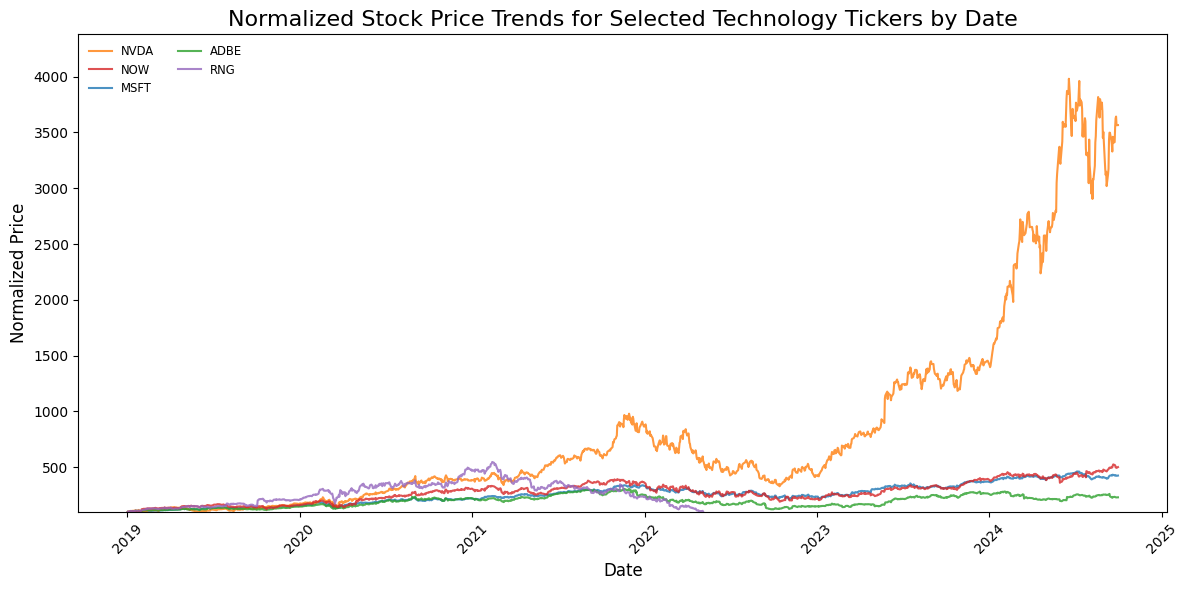

In [ ]:
# Define the specific tickers you want to plot
selected_tickers = ['NVDA', 'MSFT', 'NOW', 'ADBE', 'RNG']
# Define the specific sector you want to plot
specific_sector = "Technology"  # Replace with the desired sector name

# Filter the data for the specific sector
sector_data = stocks[stocks['Sector'] == specific_sector].copy()

# Filter the data for the specific sector and tickers
filtered_data = sector_data[sector_data['Ticker'].isin(selected_tickers)].copy()

# Normalize the data for the filtered tickers
filtered_data['Normalized Close'] = filtered_data.groupby('Ticker')['Close'].transform(
    lambda x: (x / x.iloc[0]) * 100
)

# Initialize the plot
plt.figure(figsize=(12, 6))

# Dictionary to store the final normalized values and line objects
final_values = {}
lines = {}

# Plot each selected stock and store the Line2D object
for ticker in filtered_data['Ticker'].unique():
    ticker_data = filtered_data[filtered_data['Ticker'] == ticker]
    line, = plt.plot(
        ticker_data['Date'],
        ticker_data['Normalized Close'],
        label=ticker,
        alpha=0.8
    )
    # Store the final value and the line object
    final_values[ticker] = ticker_data['Normalized Close'].iloc[-1]
    lines[ticker] = line

# Sort the tickers by final normalized values in descending order
sorted_tickers = sorted(final_values.items(), key=lambda x: x[1], reverse=True)

# Create a legend using the sorted order and corresponding line objects
sorted_labels = [ticker for ticker, value in sorted_tickers]
sorted_lines = [lines[ticker] for ticker, value in sorted_tickers]
plt.legend(sorted_lines, sorted_labels, loc="upper left", fontsize="small", ncol=2, frameon=False)

# Adjust the y-axis to start at 100 and end slightly above the maximum normalized value
plt.ylim(100, filtered_data['Normalized Close'].max() * 1.1)

# Add plot details
plt.title("Normalized Stock Price Trends for Selected Technology Tickers by Date", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Normalized Price", fontsize=12)
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()

# Show the plot
plt.show()


##### commented code not in use

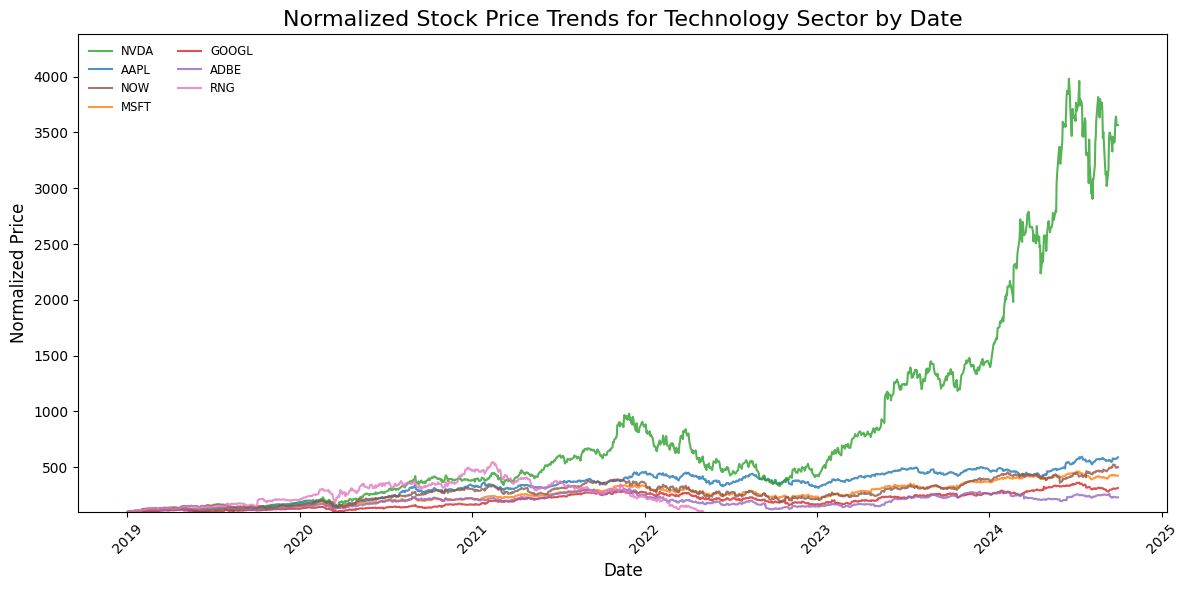

In [ ]:
"""
# Define the specific sector you want to plot
specific_sector = "Technology"  # Replace with the desired sector name

# Filter the data for the specific sector
sector_data = stocks[stocks['Sector'] == specific_sector].copy()

# Normalize the data for the sector
sector_data['Normalized Close'] = sector_data.groupby('Ticker')['Close'].transform(
    lambda x: (x / x.iloc[0]) * 100
)

# Initialize the plot
plt.figure(figsize=(12, 6))

# Dictionary to store the final normalized values and line objects
final_values = {}
lines = {}

# Plot each stock and store the Line2D object
for ticker in sector_data['Ticker'].unique():
    ticker_data = sector_data[sector_data['Ticker'] == ticker]
    line, = plt.plot(
        ticker_data['Date'],
        ticker_data['Normalized Close'],
        label=ticker,
        alpha=0.8
    )
    # Store the final value and the line object
    final_values[ticker] = ticker_data['Normalized Close'].iloc[-1]
    lines[ticker] = line

# Sort the tickers by final normalized values in descending order
sorted_tickers = sorted(final_values.items(), key=lambda x: x[1], reverse=True)

# Create a legend using the sorted order and corresponding line objects
sorted_labels = [ticker for ticker, value in sorted_tickers]
sorted_lines = [lines[ticker] for ticker, value in sorted_tickers]
plt.legend(sorted_lines, sorted_labels, loc="upper left", fontsize="small", ncol=2, frameon=False)

# Adjust the y-axis to start at 50 and end slightly above the maximum normalized value
plt.ylim(100, sector_data['Normalized Close'].max() * 1.1)

# Add plot details
plt.title(f"Normalized Stock Price Trends for {specific_sector} Sector by Date", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Normalized Price", fontsize=12)
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
#plt.grid(True, alpha=0.3)
plt.tight_layout()

# Show the plot
plt.show()
"""

# Model

## Traditional Model

#### NVDA

In [ ]:
# Load the datasets
nvda_news = pd.read_csv('Nvda_news.csv')
stock_data = pd.read_csv('stock_data.csv')

# Convert date columns to consistent format
nvda_news['datetime'] = pd.to_datetime(nvda_news['datetime'], errors='coerce').dt.date
stock_data['Date'] = pd.to_datetime(stock_data['Date'], errors='coerce').dt.date

# Merge datasets on the date column
merged_data = pd.merge(stock_data, nvda_news, left_on='Date', right_on='datetime', how='inner')

# Create target variable: 1 if Adj Close increases, 0 otherwise
merged_data['Stock_Direction'] = (merged_data['Adj Close'] > merged_data['Adj Close'].shift(1)).astype(int)
merged_data = merged_data.dropna(subset=['Stock_Direction'])

# Feature Engineering for XGBoost
merged_data['Variance'] = merged_data['High'] - merged_data['Low']
merged_data['Daily_Return'] = (merged_data['Close'] - merged_data['Open']) / merged_data['Open']
merged_data['Prev_Day_Change'] = merged_data['Adj Close'].shift(1) - merged_data['Adj Close'].shift(2)
merged_data = merged_data.dropna()  # Drop rows with NaN from shift

# Sort data by date for proper train-test splitting
merged_data = merged_data.sort_values(by='Date')

# Define date ranges for training and validation
train_end_date = pd.to_datetime("2021-01-02").date()
val_end_date = pd.to_datetime("2022-01-02").date()

# Split the data
train_data = merged_data[(merged_data['Date'] >= pd.to_datetime("2019-01-03").date()) & (merged_data['Date'] <= train_end_date)]
val_data = merged_data[(merged_data['Date'] > train_end_date) & (merged_data['Date'] <= val_end_date)]

# Debugging: Check sizes of splits
print(f"Training data size: {train_data.shape}")
print(f"Validation data size: {val_data.shape}")

# Logistic Regression
logistic_features = ['sentiment_score']
X_train_lr = train_data[logistic_features]
y_train_lr = train_data['Stock_Direction']
X_val_lr = val_data[logistic_features]
y_val_lr = val_data['Stock_Direction']

# XGBoost
xgb_features = ['sentiment_score', 'Variance', 'Daily_Return', 'Prev_Day_Change']
X_train_xgb = train_data[xgb_features]
y_train_xgb = train_data['Stock_Direction']
X_val_xgb = val_data[xgb_features]
y_val_xgb = val_data['Stock_Direction']

# Address class imbalance using SMOTE
smote = SMOTE(random_state=42)

# Logistic Regression: Balance classes
X_train_balanced_lr, y_train_balanced_lr = smote.fit_resample(X_train_lr, y_train_lr)

# XGBoost: Balance classes
X_train_balanced_xgb, y_train_balanced_xgb = smote.fit_resample(X_train_xgb, y_train_xgb)

# Scale features for XGBoost
scaler = StandardScaler()
X_train_xgb_scaled = scaler.fit_transform(X_train_balanced_xgb)
X_val_xgb_scaled = scaler.transform(X_val_xgb)

# Train Logistic Regression model
lr_model = LogisticRegression(random_state=42)
lr_model.fit(X_train_balanced_lr, y_train_balanced_lr)

# Train XGBoost model
xgb_model = XGBClassifier(scale_pos_weight=len(y_train_balanced_xgb) / sum(y_train_balanced_xgb == 1), random_state=42)
xgb_model.fit(X_train_xgb_scaled, y_train_balanced_xgb)

# Make predictions
y_pred_lr = lr_model.predict(X_val_lr)
y_pred_xgb = xgb_model.predict(X_val_xgb_scaled)
y_pred_xgb_prob = xgb_model.predict_proba(X_val_xgb_scaled)[:, 1]

# Evaluate Logistic Regression
accuracy_lr = accuracy_score(y_val_lr, y_pred_lr)
report_lr = classification_report(y_val_lr, y_pred_lr, target_names=['Class 0', 'Class 1'])

# Evaluate XGBoost
accuracy_xgb = accuracy_score(y_val_xgb, y_pred_xgb)
roc_auc_xgb = roc_auc_score(y_val_xgb, y_pred_xgb_prob)
report_xgb = classification_report(y_val_xgb, y_pred_xgb, target_names=['Class 0', 'Class 1'])

# Display Logistic Regression results
print("\nLogistic Regression Results:")
print(f"Accuracy: {accuracy_lr * 100:.2f}%")
print("\nClassification Report:\n", report_lr)

# Display XGBoost results
print("\nXGBoost Results:")
print(f"Accuracy: {accuracy_xgb * 100:.2f}%")
print(f"ROC AUC Score: {roc_auc_xgb:.2f}")
print("\nClassification Report:\n", report_xgb)

# Compare Models
print("\nComparison Summary:")
print(f"Logistic Regression Accuracy: {accuracy_lr * 100:.2f}%")
print(f"XGBoost Accuracy: {accuracy_xgb * 100:.2f}%")
print(f"XGBoost ROC AUC Score: {roc_auc_xgb:.2f}")


Training data size: (48801, 19)
Validation data size: (29070, 19)

Logistic Regression Results:
Accuracy: 42.04%

Classification Report:
               precision    recall  f1-score   support

     Class 0       0.84      0.39      0.53     24538
     Class 1       0.15      0.59      0.24      4532

    accuracy                           0.42     29070
   macro avg       0.50      0.49      0.39     29070
weighted avg       0.73      0.42      0.49     29070


XGBoost Results:
Accuracy: 59.32%
ROC AUC Score: 0.72

Classification Report:
               precision    recall  f1-score   support

     Class 0       0.93      0.56      0.70     24538
     Class 1       0.25      0.79      0.38      4532

    accuracy                           0.59     29070
   macro avg       0.59      0.67      0.54     29070
weighted avg       0.83      0.59      0.65     29070


Comparison Summary:
Logistic Regression Accuracy: 42.04%
XGBoost Accuracy: 59.32%
XGBoost ROC AUC Score: 0.72


#### MSFT

In [ ]:
# Load the datasets
msft_news = pd.read_csv('MSFT_news.csv')
stock_data = pd.read_csv('stock_data.csv')

# Convert date columns to consistent format
msft_news['datetime'] = pd.to_datetime(msft_news['datetime'], errors='coerce').dt.date
stock_data['Date'] = pd.to_datetime(stock_data['Date'], errors='coerce').dt.date

# Merge datasets on the date column
merged_data = pd.merge(stock_data, msft_news, left_on='Date', right_on='datetime', how='inner')

# Create target variable: 1 if Adj Close increases, 0 otherwise
merged_data['Stock_Direction'] = (merged_data['Adj Close'] > merged_data['Adj Close'].shift(1)).astype(int)
merged_data = merged_data.dropna(subset=['Stock_Direction'])

# Feature Engineering for XGBoost
merged_data['Variance'] = merged_data['High'] - merged_data['Low']
merged_data['Daily_Return'] = (merged_data['Close'] - merged_data['Open']) / merged_data['Open']
merged_data['Prev_Day_Change'] = merged_data['Adj Close'].shift(1) - merged_data['Adj Close'].shift(2)
merged_data = merged_data.dropna()  # Drop rows with NaN from shift

# Sort data by date for proper train-test splitting
merged_data = merged_data.sort_values(by='Date')

# Define date ranges for training and validation
train_end_date = pd.to_datetime("2021-01-02").date()
val_end_date = pd.to_datetime("2022-01-02").date()

# Split the data
train_data = merged_data[(merged_data['Date'] >= pd.to_datetime("2019-01-03").date()) & (merged_data['Date'] <= train_end_date)]
val_data = merged_data[(merged_data['Date'] > train_end_date) & (merged_data['Date'] <= val_end_date)]

# Debugging: Check sizes of splits
print(f"Training data size: {train_data.shape}")
print(f"Validation data size: {val_data.shape}")

# Logistic Regression
logistic_features = ['sentiment_score']
X_train_lr = train_data[logistic_features]
y_train_lr = train_data['Stock_Direction']
X_val_lr = val_data[logistic_features]
y_val_lr = val_data['Stock_Direction']

# XGBoost
xgb_features = ['sentiment_score', 'Variance', 'Daily_Return', 'Prev_Day_Change']
X_train_xgb = train_data[xgb_features]
y_train_xgb = train_data['Stock_Direction']
X_val_xgb = val_data[xgb_features]
y_val_xgb = val_data['Stock_Direction']

# Address class imbalance using SMOTE
smote = SMOTE(random_state=42)

# Logistic Regression: Balance classes
X_train_balanced_lr, y_train_balanced_lr = smote.fit_resample(X_train_lr, y_train_lr)

# XGBoost: Balance classes
X_train_balanced_xgb, y_train_balanced_xgb = smote.fit_resample(X_train_xgb, y_train_xgb)

# Scale features for XGBoost
scaler = StandardScaler()
X_train_xgb_scaled = scaler.fit_transform(X_train_balanced_xgb)
X_val_xgb_scaled = scaler.transform(X_val_xgb)

# Train Logistic Regression model
lr_model = LogisticRegression(random_state=42)
lr_model.fit(X_train_balanced_lr, y_train_balanced_lr)

# Train XGBoost model
xgb_model = XGBClassifier(scale_pos_weight=len(y_train_balanced_xgb) / sum(y_train_balanced_xgb == 1), random_state=42)
xgb_model.fit(X_train_xgb_scaled, y_train_balanced_xgb)

# Make predictions
y_pred_lr = lr_model.predict(X_val_lr)
y_pred_xgb = xgb_model.predict(X_val_xgb_scaled)
y_pred_xgb_prob = xgb_model.predict_proba(X_val_xgb_scaled)[:, 1]

# Evaluate Logistic Regression
accuracy_lr = accuracy_score(y_val_lr, y_pred_lr)
report_lr = classification_report(y_val_lr, y_pred_lr, target_names=['Class 0', 'Class 1'])

# Evaluate XGBoost
accuracy_xgb = accuracy_score(y_val_xgb, y_pred_xgb)
roc_auc_xgb = roc_auc_score(y_val_xgb, y_pred_xgb_prob)
report_xgb = classification_report(y_val_xgb, y_pred_xgb, target_names=['Class 0', 'Class 1'])

# Display Logistic Regression results
print("\nLogistic Regression Results:")
print(f"Accuracy: {accuracy_lr * 100:.2f}%")
print("\nClassification Report:\n", report_lr)

# Display XGBoost results
print("\nXGBoost Results:")
print(f"Accuracy: {accuracy_xgb * 100:.2f}%")
print(f"ROC AUC Score: {roc_auc_xgb:.2f}")
print("\nClassification Report:\n", report_xgb)

# Compare Models
print("\nComparison Summary:")
print(f"Logistic Regression Accuracy: {accuracy_lr * 100:.2f}%")
print(f"XGBoost Accuracy: {accuracy_xgb * 100:.2f}%")
print(f"XGBoost ROC AUC Score: {roc_auc_xgb:.2f}")


Training data size: (70002, 19)
Validation data size: (50616, 19)

Logistic Regression Results:
Accuracy: 62.59%

Classification Report:
               precision    recall  f1-score   support

     Class 0       0.89      0.66      0.76     45629
     Class 1       0.08      0.27      0.12      4987

    accuracy                           0.63     50616
   macro avg       0.49      0.47      0.44     50616
weighted avg       0.81      0.63      0.70     50616


XGBoost Results:
Accuracy: 57.40%
ROC AUC Score: 0.72

Classification Report:
               precision    recall  f1-score   support

     Class 0       0.96      0.55      0.70     45629
     Class 1       0.16      0.81      0.27      4987

    accuracy                           0.57     50616
   macro avg       0.56      0.68      0.49     50616
weighted avg       0.88      0.57      0.66     50616


Comparison Summary:
Logistic Regression Accuracy: 62.59%
XGBoost Accuracy: 57.40%
XGBoost ROC AUC Score: 0.72


#### Now

In [ ]:
# Load the datasets
now_news = pd.read_csv('Now_news.csv')
stock_data = pd.read_csv('stock_data.csv')

# Convert date columns to consistent format
now_news['datetime'] = pd.to_datetime(now_news['datetime'], errors='coerce').dt.date
stock_data['Date'] = pd.to_datetime(stock_data['Date'], errors='coerce').dt.date

# Merge datasets on the date column
merged_data = pd.merge(stock_data, now_news, left_on='Date', right_on='datetime', how='inner')

# Create target variable: 1 if Adj Close increases, 0 otherwise
merged_data['Stock_Direction'] = (merged_data['Adj Close'] > merged_data['Adj Close'].shift(1)).astype(int)
merged_data = merged_data.dropna(subset=['Stock_Direction'])

# Feature Engineering for XGBoost
merged_data['Variance'] = merged_data['High'] - merged_data['Low']
merged_data['Daily_Return'] = (merged_data['Close'] - merged_data['Open']) / merged_data['Open']
merged_data['Prev_Day_Change'] = merged_data['Adj Close'].shift(1) - merged_data['Adj Close'].shift(2)
merged_data = merged_data.dropna()  # Drop rows with NaN from shift

# Sort data by date for proper train-test splitting
merged_data = merged_data.sort_values(by='Date')

# Define date ranges for training and validation
train_end_date = pd.to_datetime("2021-01-02").date()
val_end_date = pd.to_datetime("2022-01-02").date()

# Split the data
train_data = merged_data[(merged_data['Date'] >= pd.to_datetime("2019-01-03").date()) & (merged_data['Date'] <= train_end_date)]
val_data = merged_data[(merged_data['Date'] > train_end_date) & (merged_data['Date'] <= val_end_date)]

# Debugging: Check sizes of splits
print(f"Training data size: {train_data.shape}")
print(f"Validation data size: {val_data.shape}")

# Logistic Regression
logistic_features = ['sentiment_score']
X_train_lr = train_data[logistic_features]
y_train_lr = train_data['Stock_Direction']
X_val_lr = val_data[logistic_features]
y_val_lr = val_data['Stock_Direction']

# XGBoost
xgb_features = ['sentiment_score', 'Variance', 'Daily_Return', 'Prev_Day_Change']
X_train_xgb = train_data[xgb_features]
y_train_xgb = train_data['Stock_Direction']
X_val_xgb = val_data[xgb_features]
y_val_xgb = val_data['Stock_Direction']

# Address class imbalance using SMOTE
smote = SMOTE(random_state=42)

# Logistic Regression: Balance classes
X_train_balanced_lr, y_train_balanced_lr = smote.fit_resample(X_train_lr, y_train_lr)

# XGBoost: Balance classes
X_train_balanced_xgb, y_train_balanced_xgb = smote.fit_resample(X_train_xgb, y_train_xgb)

# Scale features for XGBoost
scaler = StandardScaler()
X_train_xgb_scaled = scaler.fit_transform(X_train_balanced_xgb)
X_val_xgb_scaled = scaler.transform(X_val_xgb)

# Train Logistic Regression model
lr_model = LogisticRegression(random_state=42)
lr_model.fit(X_train_balanced_lr, y_train_balanced_lr)

# Train XGBoost model
xgb_model = XGBClassifier(scale_pos_weight=len(y_train_balanced_xgb) / sum(y_train_balanced_xgb == 1), random_state=42)
xgb_model.fit(X_train_xgb_scaled, y_train_balanced_xgb)

# Make predictions
y_pred_lr = lr_model.predict(X_val_lr)
y_pred_xgb = xgb_model.predict(X_val_xgb_scaled)
y_pred_xgb_prob = xgb_model.predict_proba(X_val_xgb_scaled)[:, 1]

# Evaluate Logistic Regression
accuracy_lr = accuracy_score(y_val_lr, y_pred_lr)
report_lr = classification_report(y_val_lr, y_pred_lr, target_names=['Class 0', 'Class 1'])

# Evaluate XGBoost
accuracy_xgb = accuracy_score(y_val_xgb, y_pred_xgb)
roc_auc_xgb = roc_auc_score(y_val_xgb, y_pred_xgb_prob)
report_xgb = classification_report(y_val_xgb, y_pred_xgb, target_names=['Class 0', 'Class 1'])

# Display Logistic Regression results
print("\nLogistic Regression Results:")
print(f"Accuracy: {accuracy_lr * 100:.2f}%")
print("\nClassification Report:\n", report_lr)

# Display XGBoost results
print("\nXGBoost Results:")
print(f"Accuracy: {accuracy_xgb * 100:.2f}%")
print(f"ROC AUC Score: {roc_auc_xgb:.2f}")
print("\nClassification Report:\n", report_xgb)

# Compare Models
print("\nComparison Summary:")
print(f"Logistic Regression Accuracy: {accuracy_lr * 100:.2f}%")
print(f"XGBoost Accuracy: {accuracy_xgb * 100:.2f}%")
print(f"XGBoost ROC AUC Score: {roc_auc_xgb:.2f}")


<ipython-input-22-15c411ae1866>:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  now_news['datetime'] = pd.to_datetime(now_news['datetime'], errors='coerce').dt.date


Training data size: (3402, 19)
Validation data size: (2926, 19)

Logistic Regression Results:
Accuracy: 54.41%

Classification Report:
               precision    recall  f1-score   support

     Class 0       0.57      0.73      0.64      1642
     Class 1       0.47      0.31      0.37      1284

    accuracy                           0.54      2926
   macro avg       0.52      0.52      0.51      2926
weighted avg       0.53      0.54      0.52      2926


XGBoost Results:
Accuracy: 55.88%
ROC AUC Score: 0.60

Classification Report:
               precision    recall  f1-score   support

     Class 0       0.67      0.41      0.51      1642
     Class 1       0.50      0.75      0.60      1284

    accuracy                           0.56      2926
   macro avg       0.59      0.58      0.55      2926
weighted avg       0.60      0.56      0.55      2926


Comparison Summary:
Logistic Regression Accuracy: 54.41%
XGBoost Accuracy: 55.88%
XGBoost ROC AUC Score: 0.60


#### ADBE

In [ ]:
# Load the datasets
adbe_news = pd.read_csv('Adbe_news.csv')
stock_data = pd.read_csv('stock_data.csv')

# Convert date columns to consistent format
adbe_news['datetime'] = pd.to_datetime(adbe_news['datetime'], errors='coerce').dt.date
stock_data['Date'] = pd.to_datetime(stock_data['Date'], errors='coerce').dt.date

# Merge datasets on the date column
merged_data = pd.merge(stock_data, adbe_news, left_on='Date', right_on='datetime', how='inner')

# Create target variable: 1 if Adj Close increases, 0 otherwise
merged_data['Stock_Direction'] = (merged_data['Adj Close'] > merged_data['Adj Close'].shift(1)).astype(int)
merged_data = merged_data.dropna(subset=['Stock_Direction'])

# Feature Engineering for XGBoost
merged_data['Variance'] = merged_data['High'] - merged_data['Low']
merged_data['Daily_Return'] = (merged_data['Close'] - merged_data['Open']) / merged_data['Open']
merged_data['Prev_Day_Change'] = merged_data['Adj Close'].shift(1) - merged_data['Adj Close'].shift(2)
merged_data = merged_data.dropna()  # Drop rows with NaN from shift

# Sort data by date for proper train-test splitting
merged_data = merged_data.sort_values(by='Date')

# Define date ranges for training and validation
train_end_date = pd.to_datetime("2021-01-02").date()
val_end_date = pd.to_datetime("2022-01-02").date()

# Split the data
train_data = merged_data[(merged_data['Date'] >= pd.to_datetime("2019-01-03").date()) & (merged_data['Date'] <= train_end_date)]
val_data = merged_data[(merged_data['Date'] > train_end_date) & (merged_data['Date'] <= val_end_date)]

# Debugging: Check sizes of splits
print(f"Training data size: {train_data.shape}")
print(f"Validation data size: {val_data.shape}")

# Logistic Regression
logistic_features = ['sentiment_score']
X_train_lr = train_data[logistic_features]
y_train_lr = train_data['Stock_Direction']
X_val_lr = val_data[logistic_features]
y_val_lr = val_data['Stock_Direction']

# XGBoost
xgb_features = ['sentiment_score', 'Variance', 'Daily_Return', 'Prev_Day_Change']
X_train_xgb = train_data[xgb_features]
y_train_xgb = train_data['Stock_Direction']
X_val_xgb = val_data[xgb_features]
y_val_xgb = val_data['Stock_Direction']

# Address class imbalance using SMOTE
smote = SMOTE(random_state=42)

# Logistic Regression: Balance classes
X_train_balanced_lr, y_train_balanced_lr = smote.fit_resample(X_train_lr, y_train_lr)

# XGBoost: Balance classes
X_train_balanced_xgb, y_train_balanced_xgb = smote.fit_resample(X_train_xgb, y_train_xgb)

# Scale features for XGBoost
scaler = StandardScaler()
X_train_xgb_scaled = scaler.fit_transform(X_train_balanced_xgb)
X_val_xgb_scaled = scaler.transform(X_val_xgb)

# Train Logistic Regression model
lr_model = LogisticRegression(random_state=42)
lr_model.fit(X_train_balanced_lr, y_train_balanced_lr)

# Train XGBoost model
xgb_model = XGBClassifier(scale_pos_weight=len(y_train_balanced_xgb) / sum(y_train_balanced_xgb == 1), random_state=42)
xgb_model.fit(X_train_xgb_scaled, y_train_balanced_xgb)

# Make predictions
y_pred_lr = lr_model.predict(X_val_lr)
y_pred_xgb = xgb_model.predict(X_val_xgb_scaled)
y_pred_xgb_prob = xgb_model.predict_proba(X_val_xgb_scaled)[:, 1]

# Evaluate Logistic Regression
accuracy_lr = accuracy_score(y_val_lr, y_pred_lr)
report_lr = classification_report(y_val_lr, y_pred_lr, target_names=['Class 0', 'Class 1'])

# Evaluate XGBoost
accuracy_xgb = accuracy_score(y_val_xgb, y_pred_xgb)
roc_auc_xgb = roc_auc_score(y_val_xgb, y_pred_xgb_prob)
report_xgb = classification_report(y_val_xgb, y_pred_xgb, target_names=['Class 0', 'Class 1'])

# Display Logistic Regression results
print("\nLogistic Regression Results:")
print(f"Accuracy: {accuracy_lr * 100:.2f}%")
print("\nClassification Report:\n", report_lr)

# Display XGBoost results
print("\nXGBoost Results:")
print(f"Accuracy: {accuracy_xgb * 100:.2f}%")
print(f"ROC AUC Score: {roc_auc_xgb:.2f}")
print("\nClassification Report:\n", report_xgb)

# Compare Models
print("\nComparison Summary:")
print(f"Logistic Regression Accuracy: {accuracy_lr * 100:.2f}%")
print(f"XGBoost Accuracy: {accuracy_xgb * 100:.2f}%")
print(f"XGBoost ROC AUC Score: {roc_auc_xgb:.2f}")

<ipython-input-23-5f021cced76a>:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  adbe_news['datetime'] = pd.to_datetime(adbe_news['datetime'], errors='coerce').dt.date


Training data size: (10654, 19)
Validation data size: (6498, 19)

Logistic Regression Results:
Accuracy: 56.80%

Classification Report:
               precision    recall  f1-score   support

     Class 0       0.70      0.65      0.67      4439
     Class 1       0.34      0.40      0.37      2059

    accuracy                           0.57      6498
   macro avg       0.52      0.52      0.52      6498
weighted avg       0.59      0.57      0.58      6498


XGBoost Results:
Accuracy: 56.57%
ROC AUC Score: 0.66

Classification Report:
               precision    recall  f1-score   support

     Class 0       0.80      0.49      0.61      4439
     Class 1       0.40      0.73      0.52      2059

    accuracy                           0.57      6498
   macro avg       0.60      0.61      0.56      6498
weighted avg       0.67      0.57      0.58      6498


Comparison Summary:
Logistic Regression Accuracy: 56.80%
XGBoost Accuracy: 56.57%
XGBoost ROC AUC Score: 0.66


## Neural Network Models

### RNN-Model

#### NVDA

In [ ]:
# Load the datasets
news_data = pd.read_csv('Nvda_news.csv')  # Replace with your local path
stock_data = pd.read_csv('stock_data.csv')  # Replace with your local path

# Convert date columns to consistent format
news_data['datetime'] = pd.to_datetime(news_data['datetime']).dt.date
stock_data['Date'] = pd.to_datetime(stock_data['Date']).dt.date

# Merge datasets on the date column
merged_data = pd.merge(stock_data, news_data, left_on='Date', right_on='datetime', how='inner')

# Create target variable: 1 if Adj Close increases, 0 otherwise
merged_data['Stock_Direction'] = (merged_data['Adj Close'] > merged_data['Adj Close'].shift(1)).astype(int)
merged_data = merged_data.dropna(subset=['Stock_Direction'])

# Sort data by date for proper train-test splitting
merged_data = merged_data.sort_values(by='Date')

# Select features and target
features = ['sentiment_score']
target = 'Stock_Direction'

# Normalize features
scaler = MinMaxScaler()
merged_data[features] = scaler.fit_transform(merged_data[features])

# Split the data into training (2 years) and validation (1 year)
train_end_date = pd.to_datetime("2021-01-02").date()
val_end_date = pd.to_datetime("2022-01-02").date()

train_data = merged_data[(merged_data['Date'] >= pd.to_datetime("2019-01-03").date()) & (merged_data['Date'] <= train_end_date)]
val_data = merged_data[(merged_data['Date'] > train_end_date) & (merged_data['Date'] <= val_end_date)]

# Prepare training and validation sets
X_train = np.array(train_data[features])
y_train = np.array(train_data[target])
X_val = np.array(val_data[features])
y_val = np.array(val_data[target])

# Reshape inputs for RNN (samples, time steps, features)
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_val = X_val.reshape((X_val.shape[0], 1, X_val.shape[1]))

# Convert targets to categorical
y_train_cat = to_categorical(y_train)
y_val_cat = to_categorical(y_val)

# Build the RNN model
model = Sequential()
model.add(SimpleRNN(50, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(2, activation='softmax'))  # Two classes: 0 and 1

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
print("\nTraining the RNN model...")
model.fit(X_train, y_train_cat, epochs=10, batch_size=32, validation_data=(X_val, y_val_cat), verbose=1)

# Make predictions
y_pred_prob = model.predict(X_val)
y_pred = np.argmax(y_pred_prob, axis=1)

# Evaluate the model
accuracy = accuracy_score(y_val, y_pred)
report = classification_report(y_val, y_pred, target_names=['Price Down/Neutral', 'Price Up'])

# Display results
print("\nRNN Model Results:")
print(f"Accuracy: {accuracy * 100:.2f}%")
print("\nClassification Report:\n", report)



Training the RNN model...
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1526/1526 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.7824 - loss: 0.4984 - val_accuracy: 0.8441 - val_loss: 0.4345
Epoch 2/10
1526/1526 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8366 - loss: 0.4457 - val_accuracy: 0.8441 - val_loss: 0.4337
Epoch 3/10
1526/1526 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8364 - loss: 0.4457 - val_accuracy: 0.8441 - val_loss: 0.4353
Epoch 4/10
1526/1526 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8360 - loss: 0.4465 - val_accuracy: 0.8441 - val_loss: 0.4338
Epoch 5/10
1526/1526 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.8362 - loss: 0.4460 - val_accuracy: 0.8441 - val_loss: 0.4335
Epoch 6/10
1526/1526 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8357 - loss: 0.4468 - val_accuracy: 0.8441 - val_loss: 0.4344
Epoch 7/10
1526/1526 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.8363 - loss: 0.4462 - val_accuracy: 0.8441 - val_loss: 0.4343
Epoch 8/10
1526/1526 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8355 - loss: 0.4472 - val_accurac

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


#### MSFT

In [ ]:
# Load the datasets
msft_news_data = pd.read_csv('MSFT_news.csv')  # Replace with your local path
stock_data = pd.read_csv('stock_data.csv')  # Replace with your local path

# Convert date columns to consistent format
msft_news_data['datetime'] = pd.to_datetime(msft_news_data['datetime']).dt.date
stock_data['Date'] = pd.to_datetime(stock_data['Date']).dt.date

# Merge datasets on the date column
merged_data = pd.merge(stock_data, msft_news_data, left_on='Date', right_on='datetime', how='inner')

# Create target variable: 1 if Adj Close increases, 0 otherwise
merged_data['Stock_Direction'] = (merged_data['Adj Close'] > merged_data['Adj Close'].shift(1)).astype(int)
merged_data = merged_data.dropna(subset=['Stock_Direction'])

# Sort data by date for proper train-test splitting
merged_data = merged_data.sort_values(by='Date')

# Select features and target
features = ['sentiment_score']
target = 'Stock_Direction'

# Normalize features
scaler = MinMaxScaler()
merged_data[features] = scaler.fit_transform(merged_data[features])

# Split the data into training (2 years) and validation (1 year)
train_end_date = pd.to_datetime("2021-01-02").date()
val_end_date = pd.to_datetime("2022-01-02").date()

train_data = merged_data[(merged_data['Date'] >= pd.to_datetime("2019-01-03").date()) & (merged_data['Date'] <= train_end_date)]
val_data = merged_data[(merged_data['Date'] > train_end_date) & (merged_data['Date'] <= val_end_date)]

# Prepare training and validation sets
X_train = np.array(train_data[features])
y_train = np.array(train_data[target])
X_val = np.array(val_data[features])
y_val = np.array(val_data[target])

# Reshape inputs for RNN (samples, time steps, features)
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_val = X_val.reshape((X_val.shape[0], 1, X_val.shape[1]))

# Convert targets to categorical
y_train_cat = to_categorical(y_train)
y_val_cat = to_categorical(y_val)

# Build the RNN model
model = Sequential()
model.add(SimpleRNN(50, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(2, activation='softmax'))  # Two classes: 0 and 1

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
print("\nTraining the RNN model...")
model.fit(X_train, y_train_cat, epochs=10, batch_size=32, validation_data=(X_val, y_val_cat), verbose=1)

# Make predictions
y_pred_prob = model.predict(X_val)
y_pred = np.argmax(y_pred_prob, axis=1)

# Evaluate the model
accuracy = accuracy_score(y_val, y_pred)
report = classification_report(y_val, y_pred, target_names=['Price Down/Neutral', 'Price Up'])

# Display results
print("\nRNN Model Results:")
print(f"Accuracy: {accuracy * 100:.2f}%")
print("\nClassification Report:\n", report)


Training the RNN model...
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2188/2188 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9227 - loss: 0.3158 - val_accuracy: 0.9015 - val_loss: 0.3223
Epoch 2/10
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.9239 - loss: 0.2704 - val_accuracy: 0.9015 - val_loss: 0.3275
Epoch 3/10
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9233 - loss: 0.2711 - val_accuracy: 0.9015 - val_loss: 0.3248
Epoch 4/10
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9225 - loss: 0.2729 - val_accuracy: 0.9015 - val_loss: 0.3281
Epoch 5/10
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9226 - loss: 0.2728 - val_accuracy: 0.9015 - val_loss: 0.3239
Epoch 6/10
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9217 - loss: 0.2749 - val_accuracy: 0.9015 - val_loss: 0.3227
Epoch 7/10
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.9225 - loss: 0.2730 - val_accuracy: 0.9015 - val_loss: 0.3264
Epoch 8/10
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.9223 - loss: 0.2734 - val_ac

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


#### Now

In [ ]:
# Load the datasets
now_news= pd.read_csv('Now_news.csv')  # Updated to Now news data  # Updated to NVDA news data
stock_data = pd.read_csv('stock_data.csv')  # Replace with your local path

# Convert date columns to consistent format
now_news['datetime'] = pd.to_datetime(now_news['datetime']).dt.date
stock_data['Date'] = pd.to_datetime(stock_data['Date']).dt.date

# Merge datasets on the date column
merged_data = pd.merge(stock_data, now_news, left_on='Date', right_on='datetime', how='inner')

# Create target variable: 1 if Adj Close increases, 0 otherwise
merged_data['Stock_Direction'] = (merged_data['Adj Close'] > merged_data['Adj Close'].shift(1)).astype(int)
merged_data = merged_data.dropna(subset=['Stock_Direction'])

# Sort data by date for proper train-test splitting
merged_data = merged_data.sort_values(by='Date')

# Select features and target
features = ['sentiment_score']
target = 'Stock_Direction'

# Normalize features
scaler = MinMaxScaler()
merged_data[features] = scaler.fit_transform(merged_data[features])

# Split the data into training (2 years) and validation (1 year)
train_end_date = pd.to_datetime("2021-01-02").date()
val_end_date = pd.to_datetime("2022-01-02").date()

train_data = merged_data[(merged_data['Date'] >= pd.to_datetime("2019-01-03").date()) & (merged_data['Date'] <= train_end_date)]
val_data = merged_data[(merged_data['Date'] > train_end_date) & (merged_data['Date'] <= val_end_date)]

# Prepare training and validation sets
X_train = np.array(train_data[features])
y_train = np.array(train_data[target])
X_val = np.array(val_data[features])
y_val = np.array(val_data[target])

# Reshape inputs for RNN (samples, time steps, features)
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_val = X_val.reshape((X_val.shape[0], 1, X_val.shape[1]))

# Convert targets to categorical
y_train_cat = to_categorical(y_train)
y_val_cat = to_categorical(y_val)

# Build the RNN model
model = Sequential()
model.add(SimpleRNN(50, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(2, activation='softmax'))  # Two classes: 0 and 1

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
print("\nTraining the RNN model...")
model.fit(X_train, y_train_cat, epochs=10, batch_size=32, validation_data=(X_val, y_val_cat), verbose=1)

# Make predictions
y_pred_prob = model.predict(X_val)
y_pred = np.argmax(y_pred_prob, axis=1)

# Evaluate the model
accuracy = accuracy_score(y_val, y_pred)
report = classification_report(y_val, y_pred, target_names=['Price Down/Neutral', 'Price Up'])

# Display results
print("\nRNN Model Results:")
print(f"Accuracy: {accuracy * 100:.2f}%")
print("\nClassification Report:\n", report)


<ipython-input-28-b089481cfe1c>:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  now_news['datetime'] = pd.to_datetime(now_news['datetime']).dt.date



Training the RNN model...
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


107/107 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.5217 - loss: 0.6907 - val_accuracy: 0.5612 - val_loss: 0.6862
Epoch 2/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5504 - loss: 0.6886 - val_accuracy: 0.5612 - val_loss: 0.6861
Epoch 3/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5483 - loss: 0.6889 - val_accuracy: 0.5612 - val_loss: 0.6861
Epoch 4/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5608 - loss: 0.6861 - val_accuracy: 0.5612 - val_loss: 0.6864
Epoch 5/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5614 - loss: 0.6867 - val_accuracy: 0.5612 - val_loss: 0.6861
Epoch 6/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5615 - loss: 0.6862 - val_accuracy: 0.5612 - val_loss: 0.6860
Epoch 7/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5534 - loss: 0.6876 - val_accuracy: 0.5612 - val_loss: 0.6858
Epoch 8/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5606 - loss: 0.6863 - val_accuracy: 0.5612 - val

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


#### ADBE

In [ ]:
# Load the datasets
adbe_news_data = pd.read_csv('Adbe_news.csv')  # Replace with your local path
stock_data = pd.read_csv('stock_data.csv')  # Replace with your local path

# Convert date columns to consistent format
adbe_news_data['datetime'] = pd.to_datetime(adbe_news_data['datetime']).dt.date
stock_data['Date'] = pd.to_datetime(stock_data['Date']).dt.date

# Merge datasets on the date column
merged_data = pd.merge(stock_data, adbe_news_data, left_on='Date', right_on='datetime', how='inner')

# Create target variable: 1 if Adj Close increases, 0 otherwise
merged_data['Stock_Direction'] = (merged_data['Adj Close'] > merged_data['Adj Close'].shift(1)).astype(int)
merged_data = merged_data.dropna(subset=['Stock_Direction'])

# Sort data by date for proper train-test splitting
merged_data = merged_data.sort_values(by='Date')

# Select features and target
features = ['sentiment_score']
target = 'Stock_Direction'

# Normalize features
scaler = MinMaxScaler()
merged_data[features] = scaler.fit_transform(merged_data[features])

# Split the data into training (2 years) and validation (1 year)
train_end_date = pd.to_datetime("2021-01-02").date()
val_end_date = pd.to_datetime("2022-01-02").date()

train_data = merged_data[(merged_data['Date'] >= pd.to_datetime("2019-01-03").date()) & (merged_data['Date'] <= train_end_date)]
val_data = merged_data[(merged_data['Date'] > train_end_date) & (merged_data['Date'] <= val_end_date)]

# Prepare training and validation sets
X_train = np.array(train_data[features])
y_train = np.array(train_data[target])
X_val = np.array(val_data[features])
y_val = np.array(val_data[target])

# Reshape inputs for RNN (samples, time steps, features)
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_val = X_val.reshape((X_val.shape[0], 1, X_val.shape[1]))

# Convert targets to categorical
y_train_cat = to_categorical(y_train)
y_val_cat = to_categorical(y_val)

# Build the RNN model
model = Sequential()
model.add(SimpleRNN(50, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(2, activation='softmax'))  # Two classes: 0 and 1

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
print("\nTraining the RNN model...")
model.fit(X_train, y_train_cat, epochs=10, batch_size=32, validation_data=(X_val, y_val_cat), verbose=1)

# Make predictions
y_pred_prob = model.predict(X_val)
y_pred = np.argmax(y_pred_prob, axis=1)

# Evaluate the model
accuracy = accuracy_score(y_val, y_pred)
report = classification_report(y_val, y_pred, target_names=['Price Down/Neutral', 'Price Up'])

# Display results
print("\nRNN Model Results:")
print(f"Accuracy: {accuracy * 100:.2f}%")
print("\nClassification Report:\n", report)

<ipython-input-33-0b3fe33b86ba>:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  adbe_news_data['datetime'] = pd.to_datetime(adbe_news_data['datetime']).dt.date



Training the RNN model...
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


333/333 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.6684 - loss: 0.6475 - val_accuracy: 0.6831 - val_loss: 0.6286
Epoch 2/10
333/333 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6697 - loss: 0.6361 - val_accuracy: 0.6831 - val_loss: 0.6274
Epoch 3/10
333/333 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6587 - loss: 0.6429 - val_accuracy: 0.6831 - val_loss: 0.6261
Epoch 4/10
333/333 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6644 - loss: 0.6390 - val_accuracy: 0.6831 - val_loss: 0.6257
Epoch 5/10
333/333 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6653 - loss: 0.6379 - val_accuracy: 0.6831 - val_loss: 0.6252
Epoch 6/10
333/333 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6721 - loss: 0.6328 - val_accuracy: 0.6831 - val_loss: 0.6251
Epoch 7/10
333/333 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6711 - loss: 0.6336 - val_accuracy: 0.6831 - val_loss: 0.6256
Epoch 8/10
333/333 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6682 - loss: 0.6356 - val_accuracy: 0.6831 - val

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### LSTM

#### NVDA

In [ ]:
# Load the datasets
news_data = pd.read_csv('Nvda_news.csv')  # Replace with your local path
stock_data = pd.read_csv('stock_data.csv')  # Replace with your local path

# Convert date columns to consistent format
news_data['datetime'] = pd.to_datetime(news_data['datetime']).dt.date
stock_data['Date'] = pd.to_datetime(stock_data['Date']).dt.date

# Merge datasets on the date column
merged_data = pd.merge(stock_data, news_data, left_on='Date', right_on='datetime', how='inner')

# Create target variable: 1 if Adj Close increases, 0 otherwise
merged_data['Stock_Direction'] = (merged_data['Adj Close'] > merged_data['Adj Close'].shift(1)).astype(int)
merged_data = merged_data.dropna(subset=['Stock_Direction'])

# Sort data by date for proper train-test splitting
merged_data = merged_data.sort_values(by='Date')

# Select features and target
features = ['sentiment_score']
target = 'Stock_Direction'

# Normalize features
scaler = MinMaxScaler()
merged_data[features] = scaler.fit_transform(merged_data[features])

# Split the data into training (2 years) and validation (1 year)
train_end_date = pd.to_datetime("2021-01-02").date()
val_end_date = pd.to_datetime("2022-01-02").date()

train_data = merged_data[(merged_data['Date'] >= pd.to_datetime("2019-01-03").date()) & (merged_data['Date'] <= train_end_date)]
val_data = merged_data[(merged_data['Date'] > train_end_date) & (merged_data['Date'] <= val_end_date)]

# Prepare training and validation sets
X_train = np.array(train_data[features])
y_train = np.array(train_data[target])
X_val = np.array(val_data[features])
y_val = np.array(val_data[target])

# Reshape inputs for LSTM (samples, time steps, features)
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_val = X_val.reshape((X_val.shape[0], 1, X_val.shape[1]))

# Convert targets to categorical
y_train_cat = to_categorical(y_train)
y_val_cat = to_categorical(y_val)

# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = dict(enumerate(class_weights))

# Build the LSTM model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(2, activation='softmax'))  # Two classes: 0 and 1

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model with class weights
print("\nTraining the LSTM model...")
model.fit(X_train, y_train_cat, epochs=10, batch_size=32, validation_data=(X_val, y_val_cat), class_weight=class_weights_dict, verbose=1)

# Make predictions
y_pred_prob = model.predict(X_val)
y_pred = np.argmax(y_pred_prob, axis=1)

# Evaluate the model
accuracy = accuracy_score(y_val, y_pred)
report = classification_report(y_val, y_pred, target_names=['Price Down/Neutral', 'Price Up'])

# Display results
print("\nLSTM Model Results:")
print(f"Accuracy: {accuracy * 100:.2f}%")
print("\nClassification Report:\n", report)


Training the LSTM model...
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1526/1526 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5879 - loss: 0.6934 - val_accuracy: 0.1559 - val_loss: 0.7039
Epoch 2/10
1526/1526 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.3143 - loss: 0.6933 - val_accuracy: 0.2061 - val_loss: 0.6987
Epoch 3/10
1526/1526 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.4603 - loss: 0.6927 - val_accuracy: 0.2923 - val_loss: 0.6982
Epoch 4/10
1526/1526 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.4585 - loss: 0.6926 - val_accuracy: 0.3724 - val_loss: 0.6945
Epoch 5/10
1526/1526 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.4658 - loss: 0.6947 - val_accuracy: 0.2917 - val_loss: 0.6999
Epoch 6/10
1526/1526 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.4532 - loss: 0.6909 - val_accuracy: 0.3074 - val_loss: 0.6988
Epoch 7/10
1526/1526 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.6267 - loss: 0.6844 - val_accuracy: 0.3103 - val_loss: 0.6983
Epoch 8/10
1526/1526 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.3821 - loss: 0.6924 - val_accurac

#### MSFT

In [ ]:
# Load the datasets
msft_news_data = pd.read_csv('MSFT_news.csv')  # Replace with your local path
stock_data = pd.read_csv('stock_data.csv')  # Replace with your local path

# Convert date columns to consistent format
msft_news_data['datetime'] = pd.to_datetime(msft_news_data['datetime']).dt.date
stock_data['Date'] = pd.to_datetime(stock_data['Date']).dt.date

# Merge datasets on the date column
merged_data = pd.merge(stock_data, msft_news_data, left_on='Date', right_on='datetime', how='inner')

# Create target variable: 1 if Adj Close increases, 0 otherwise
merged_data['Stock_Direction'] = (merged_data['Adj Close'] > merged_data['Adj Close'].shift(1)).astype(int)
merged_data = merged_data.dropna(subset=['Stock_Direction'])

# Sort data by date for proper train-test splitting
merged_data = merged_data.sort_values(by='Date')

# Select features and target
features = ['sentiment_score']
target = 'Stock_Direction'

# Normalize features
scaler = MinMaxScaler()
merged_data[features] = scaler.fit_transform(merged_data[features])

# Split the data into training (2 years) and validation (1 year)
train_end_date = pd.to_datetime("2021-01-02").date()
val_end_date = pd.to_datetime("2022-01-02").date()

train_data = merged_data[(merged_data['Date'] >= pd.to_datetime("2019-01-03").date()) & (merged_data['Date'] <= train_end_date)]
val_data = merged_data[(merged_data['Date'] > train_end_date) & (merged_data['Date'] <= val_end_date)]

# Prepare training and validation sets
X_train = np.array(train_data[features])
y_train = np.array(train_data[target])
X_val = np.array(val_data[features])
y_val = np.array(val_data[target])

# Reshape inputs for LSTM (samples, time steps, features)
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_val = X_val.reshape((X_val.shape[0], 1, X_val.shape[1]))

# Convert targets to categorical
y_train_cat = to_categorical(y_train)
y_val_cat = to_categorical(y_val)

# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = dict(enumerate(class_weights))

# Build the LSTM model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(2, activation='softmax'))  # Two classes: 0 and 1

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model with class weights
print("\nTraining the LSTM model...")
model.fit(X_train, y_train_cat, epochs=10, batch_size=32, validation_data=(X_val, y_val_cat), class_weight=class_weights_dict, verbose=1)

# Make predictions
y_pred_prob = model.predict(X_val)
y_pred = np.argmax(y_pred_prob, axis=1)

# Evaluate the model
accuracy = accuracy_score(y_val, y_pred)
report = classification_report(y_val, y_pred, target_names=['Price Down/Neutral', 'Price Up'])

# Display results
print("\nLSTM Model Results:")
print(f"Accuracy: {accuracy * 100:.2f}%")
print("\nClassification Report:\n", report)


Training the LSTM model...
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2188/2188 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.2546 - loss: 0.6999 - val_accuracy: 0.9015 - val_loss: 0.6733
Epoch 2/10
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.5182 - loss: 0.6956 - val_accuracy: 0.1005 - val_loss: 0.7036
Epoch 3/10
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.4321 - loss: 0.6917 - val_accuracy: 0.9015 - val_loss: 0.6805
Epoch 4/10
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5600 - loss: 0.6985 - val_accuracy: 0.9015 - val_loss: 0.6765
Epoch 5/10
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.7329 - loss: 0.6897 - val_accuracy: 0.1279 - val_loss: 0.6998
Epoch 6/10
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.5053 - loss: 0.6904 - val_accuracy: 0.1364 - val_loss: 0.7001
Epoch 7/10
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.4220 - loss: 0.6955 - val_accuracy: 0.1137 - val_loss: 0.7055
Epoch 8/10
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.2732 - loss: 0.7032 - val_accu

#### NOW

In [ ]:
# Load the datasets
now_news= pd.read_csv('Now_news.csv')  # Updated to Now news data  # Updated to NVDA news data
stock_data = pd.read_csv('stock_data.csv')  # Replace with your local path

# Convert date columns to consistent format
now_news['datetime'] = pd.to_datetime(now_news['datetime']).dt.date
stock_data['Date'] = pd.to_datetime(stock_data['Date']).dt.date

# Merge datasets on the date column
merged_data = pd.merge(stock_data, now_news, left_on='Date', right_on='datetime', how='inner')
# Create target variable: 1 if Adj Close increases, 0 otherwise
merged_data['Stock_Direction'] = (merged_data['Adj Close'] > merged_data['Adj Close'].shift(1)).astype(int)
merged_data = merged_data.dropna(subset=['Stock_Direction'])

# Sort data by date for proper train-test splitting
merged_data = merged_data.sort_values(by='Date')

# Select features and target
features = ['sentiment_score']
target = 'Stock_Direction'

# Normalize features
scaler = MinMaxScaler()
merged_data[features] = scaler.fit_transform(merged_data[features])

# Split the data into training (2 years) and validation (1 year)
train_end_date = pd.to_datetime("2021-01-02").date()
val_end_date = pd.to_datetime("2022-01-02").date()

train_data = merged_data[(merged_data['Date'] >= pd.to_datetime("2019-01-03").date()) & (merged_data['Date'] <= train_end_date)]
val_data = merged_data[(merged_data['Date'] > train_end_date) & (merged_data['Date'] <= val_end_date)]

# Prepare training and validation sets
X_train = np.array(train_data[features])
y_train = np.array(train_data[target])
X_val = np.array(val_data[features])
y_val = np.array(val_data[target])

# Reshape inputs for LSTM (samples, time steps, features)
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_val = X_val.reshape((X_val.shape[0], 1, X_val.shape[1]))

# Convert targets to categorical
y_train_cat = to_categorical(y_train)
y_val_cat = to_categorical(y_val)

# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = dict(enumerate(class_weights))

# Build the LSTM model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(2, activation='softmax'))  # Two classes: 0 and 1

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model with class weights
print("\nTraining the LSTM model...")
model.fit(X_train, y_train_cat, epochs=10, batch_size=32, validation_data=(X_val, y_val_cat), class_weight=class_weights_dict, verbose=1)

# Make predictions
y_pred_prob = model.predict(X_val)
y_pred = np.argmax(y_pred_prob, axis=1)

# Evaluate the model
accuracy = accuracy_score(y_val, y_pred)
report = classification_report(y_val, y_pred, target_names=['Price Down/Neutral', 'Price Up'])

# Display results
print("\nLSTM Model Results:")
print(f"Accuracy: {accuracy * 100:.2f}%")
print("\nClassification Report:\n", report)

<ipython-input-38-20a3bae6c33e>:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  now_news['datetime'] = pd.to_datetime(now_news['datetime']).dt.date



Training the LSTM model...
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


107/107 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.5592 - loss: 0.6917 - val_accuracy: 0.4388 - val_loss: 0.6934
Epoch 2/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4523 - loss: 0.6940 - val_accuracy: 0.5612 - val_loss: 0.6930
Epoch 3/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4911 - loss: 0.6937 - val_accuracy: 0.5783 - val_loss: 0.6931
Epoch 4/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5557 - loss: 0.6917 - val_accuracy: 0.5311 - val_loss: 0.6931
Epoch 5/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4825 - loss: 0.6938 - val_accuracy: 0.5728 - val_loss: 0.6930
Epoch 6/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4594 - loss: 0.6930 - val_accuracy: 0.5311 - val_loss: 0.6931
Epoch 7/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4465 - loss: 0.6947 - val_accuracy: 0.4368 - val_loss: 0.6935
Epoch 8/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5100 - loss: 0.6910 - val_accuracy: 0.4388 - val

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


#### ADBE

In [ ]:
# Load the datasets
adobe_news = pd.read_csv('Adbe_news.csv')
stock_data = pd.read_csv('stock_data.csv')

# Convert date columns to consistent format
adobe_news['datetime'] = pd.to_datetime(adobe_news['datetime']).dt.date
stock_data['Date'] = pd.to_datetime(stock_data['Date']).dt.date

# Merge datasets on the date column
merged_data = pd.merge(stock_data, adobe_news, left_on='Date', right_on='datetime', how='inner')

# Create target variable: 1 if Adj Close increases, 0 otherwise
merged_data['Stock_Direction'] = (merged_data['Adj Close'] > merged_data['Adj Close'].shift(1)).astype(int)
merged_data = merged_data.dropna(subset=['Stock_Direction'])

# Sort data by date for proper train-test splitting
merged_data = merged_data.sort_values(by='Date')

# Select features and target
features = ['sentiment_score']
target = 'Stock_Direction'

# Normalize features
scaler = MinMaxScaler()
merged_data[features] = scaler.fit_transform(merged_data[features])

# Split the data into training (2 years) and validation (1 year)
train_end_date = pd.to_datetime("2021-01-02").date()
val_end_date = pd.to_datetime("2022-01-02").date()

train_data = merged_data[(merged_data['Date'] >= pd.to_datetime("2019-01-03").date()) & (merged_data['Date'] <= train_end_date)]
val_data = merged_data[(merged_data['Date'] > train_end_date) & (merged_data['Date'] <= val_end_date)]

# Prepare training and validation sets
X_train = np.array(train_data[features])
y_train = np.array(train_data[target])
X_val = np.array(val_data[features])
y_val = np.array(val_data[target])

# Reshape inputs for LSTM (samples, time steps, features)
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_val = X_val.reshape((X_val.shape[0], 1, X_val.shape[1]))

# Convert targets to categorical
y_train_cat = to_categorical(y_train)
y_val_cat = to_categorical(y_val)

# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = dict(enumerate(class_weights))

# Build the LSTM model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(2, activation='softmax'))  # Two classes: 0 and 1

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model with class weights
print("\nTraining the LSTM model...")
model.fit(X_train, y_train_cat, epochs=10, batch_size=32, validation_data=(X_val, y_val_cat), class_weight=class_weights_dict, verbose=1)

# Make predictions
y_pred_prob = model.predict(X_val)
y_pred = np.argmax(y_pred_prob, axis=1)

# Evaluate the model
accuracy = accuracy_score(y_val, y_pred)
report = classification_report(y_val, y_pred, target_names=['Price Down/Neutral', 'Price Up'])

# Display results
print("\nLSTM Model Results:")
print(f"Accuracy: {accuracy * 100:.2f}%")
print("\nClassification Report:\n", report)

<ipython-input-39-f97829b31b65>:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  adobe_news['datetime'] = pd.to_datetime(adobe_news['datetime']).dt.date



Training the LSTM model...
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


333/333 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.4203 - loss: 0.6948 - val_accuracy: 0.6831 - val_loss: 0.6905
Epoch 2/10
333/333 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6412 - loss: 0.6912 - val_accuracy: 0.3169 - val_loss: 0.6964
Epoch 3/10
333/333 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3637 - loss: 0.6936 - val_accuracy: 0.5674 - val_loss: 0.6931
Epoch 4/10
333/333 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5467 - loss: 0.6935 - val_accuracy: 0.5794 - val_loss: 0.6925
Epoch 5/10
333/333 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3960 - loss: 0.6969 - val_accuracy: 0.6831 - val_loss: 0.6881
Epoch 6/10
333/333 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5999 - loss: 0.6947 - val_accuracy: 0.6016 - val_loss: 0.6915
Epoch 7/10
333/333 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5122 - loss: 0.6984 - val_accuracy: 0.5794 - val_loss: 0.6925
Epoch 8/10
333/333 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4850 - loss: 0.6964 - val_accuracy: 0.5702 - val_